# DrivenData - DengAI: Predicting Disease Spread Competition

Dengue fever is a significant global health concern, especially in tropical and subtropical regions where the Aedes mosquito, the primary vector for the disease, thrives. The accurate prediction of dengue cases can assist in early warning systems, enabling health authorities to implement timely measures such as vector control and public health advisories. In this notebook, we present an approach for dengue spread prediction, developed for submission in a [DrivenData data science competition](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/). Utilizing the provided dataset, which includes weather conditions (e.g., temperature, humidity, rainfall) and vegetation cover measured by the Normalized Difference Vegetation Index (NDVI), the objective is to forecast the weekly number of dengue cases in two cities: San Juan, Puerto Rico, and Iquitos, Peru.

_This submission placed in the 39th position on the leaderboard (teofc111), ranking within the top 1% of [submissions](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/leaderboard/)._

In [1]:
# Imports
import os
import re
from __future__ import print_function
from __future__ import division
from typing import List, Optional, Iterable, Union, Dict
import copy
from numba import cuda
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from itertools import combinations

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import statsmodels.api as sm
from scipy.signal import medfilt

import xgboost as xgb # environment on thinkpad uses 2.0.3
from xgboost.sklearn import XGBClassifier
import catboost as cb # Requires numpy < 2.0.0

from warnings import filterwarnings
filterwarnings('ignore')

## Table of Contents

1. [Approach](#Approach)
2. [Data](#Data)
3. [Helpers](#Helpers)
4. [Modelling Considerations](#Modelling-Considerations)
5. [Illustration of Multi-step Forecasting Difficulties](#Illustration-of-Multi-step-Forecasting-Difficulties)
6. [Lagged Target Paradox](#Lagged-Target-Paradox)
7. [Feature Lags](#Feature-Lags)
8. [Week of Year Effect](#Week-of-Year-Effect)
11. [San Juan Model](#San-Juan-Model)
13. [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Approach

__Auto-regression with XGBoost:__
In this notebook, an autoregressive model is implemented using XGBoost, making use of lagged features as well as lagged target values for training.

__Multi-step Forecasting Treatment:__
Given the multi-step forecasting nature of the problem, special techniques were applied to adapt XGBoost for predicting multiple time points ahead, to compensate for the lack of native multi-step forecasting support. Speficially, a multi-step prediction algorithm is used to make sequential predictions at every timestep, simultaneously updating the subsequent timesteps' lagged target values with the newly predicted target value from the current timestep.

__Hyperparameter Tuning and Model Construction:__
The XGBoost model hyperparameters and lags to adopt were selected via cross-validation. As the XGBoost model is trained under the assumption of perfect knowledge of lagged target values, the training objective does not correspond directly to the multi-step forecasting scenario, with uncertainties associated with lagged target used for later timesteps. In this notebook, we account for these effects (elaborated below) when selecting the appropriate model parameters.

## Data

As shown below, the weekly dataset consists of:
1. Date information given by `year`, `weekofyear` and `week_start_date`;
2. Vegetation cover information in the ndvi features;
3. Weather/climate information
4. Location details given by the `city` feature, indicating whether the data point is from San Juan (sj) or Iquitos (iq).
5. The target `total_cases` giving the total number of dengue cases for a given week.

In [2]:
# Load the provided data
datapath = r'./data'
train_features_or = pd.read_csv(datapath+'/dengue_features_train.csv',
                             index_col=[1,2])
train_features_or.reset_index(inplace=True)

test_features_or = pd.read_csv(datapath+'/dengue_features_test.csv',
                             index_col=[1,2])
test_features_or.reset_index(inplace=True)

test_features_aug_or = pd.read_csv(datapath+'/dengue_features_test2.csv',
                             index_col=[1,2])
test_features_aug_or.reset_index(inplace=True)

train_labels = pd.read_csv(datapath+'/dengue_labels_train.csv',
                           index_col=[1,2])
train_labels = train_labels.reset_index()
train_labels.drop(columns=['city','year','weekofyear'],inplace=True)

# Rearranging features for clearer viewing with heatmap # REMOVE
feature_names = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]

In [3]:
# Features
train_features_or.sample(5)

year  weekofyear city week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
318  1996          24   sj      1996-06-10  0.098600  0.089300  0.123750   
225  1994          34   sj      1994-08-27  0.156400  0.130825  0.192057   
998  2001          37   iq      2001-09-10  0.308457  0.250314  0.298300   
511  2000           8   sj      2000-02-26       NaN  0.207500  0.150757   
115  1992          29   sj      1992-07-15  0.112000  0.125500  0.142140   

      ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
318  0.135450                 27.82             298.742857  ...   
225  0.176729                  3.24             300.364286  ...   
998  0.429071                 36.20             298.665714  ...   
511  0.146917                  7.67             297.088571  ...   
115  0.182533                 94.14             299.790000  ...   

     reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
318                            43.30                             82.235714   
225                            11.56                             76.920000   
998                            19.60                             78.957143   
511                            13.41                             74.064286   
115                            46.10                             80.150000   

     reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
318                         27.82                              16.800000   
225                          3.24                              17.338571   
998                         36.20                              15.658571   
511                          7.67                              13.670000   
115                         94.14                              17.430000   

     reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
318           2.028571           26.942857                 5.985714   
225           2.642857           28.571429                 6.700000   
998          13.785714           27.375000                11.525000   
511           1.985714           24.771429                 6.628571   
115           2.000000           27.628571                 6.042857   

     station_max_temp_c  station_min_temp_c  station_precip_mm  
318                31.1                23.3               40.9  
225                32.8                24.4                4.3  
998                35.2                20.1               41.9  
511                28.3                20.6                3.8  
115                31.7                23.9               45.2  

[5 rows x 24 columns]

In [4]:
# Target
train_labels.sample(5)

total_cases
176           27
772            5
218           42
356           18
666            6

Note that dates for the test set used for prediction/submission follows off from the end of the train set dates. Taking advantage of this knowledge, the 'dengue_features_test2.csv' dataset is an augmented version of the original dengue_features_test.csv' dataset provided, with the early week entries holding lagged target values, obtained from the train dataset. This is loaded to the `test_features_aug_or` dataframe as shown below.

In [5]:
test_features_aug_or.head(5)

year  weekofyear city week_start_date  ndvi_ne   ndvi_nw   ndvi_se  \
0  2008          18   sj        29-04-08  -0.0189 -0.018900  0.102729   
1  2008          19   sj        06-05-08  -0.0180 -0.012400  0.082043   
2  2008          20   sj        13-05-08  -0.0015       NaN  0.151083   
3  2008          21   sj        20-05-08      NaN -0.019867  0.124329   
4  2008          22   sj        27-05-08   0.0568  0.039833  0.062267   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  total_cases_11  \
0  0.091200                 78.60             298.492857  ...             6.0   
1  0.072314                 12.56             298.475714  ...             8.0   
2  0.091529                  3.66             299.455714  ...             5.0   
3  0.125686                  0.00             299.690000  ...             1.0   
4  0.075914                  0.76             299.780000  ...             2.0   

   total_cases_12  total_cases_13  total_cases_14  total_cases_15  \
0             2.0             9.0            10.0            15.0   
1             6.0             2.0             9.0            10.0   
2             8.0             6.0             2.0             9.0   
3             5.0             8.0             6.0             2.0   
4             1.0             5.0             8.0             6.0   

   total_cases_16  total_cases_17  total_cases_18  total_cases_19  \
0            14.0            15.0            17.0            13.0   
1            15.0            14.0            15.0            17.0   
2            10.0            15.0            14.0            15.0   
3             9.0            10.0            15.0            14.0   
4             2.0             9.0            10.0            15.0   

   total_cases_20  
0            12.0  
1            13.0  
2            17.0  
3            15.0  
4            14.0  

[5 rows x 44 columns]

 As shown below, San Juan (sj) shows much higher dengue cases compared to Iquitos (iq). For the purpose scoring well in the competition, our strategy is to focus on lowering the error for predictions in San Juan.

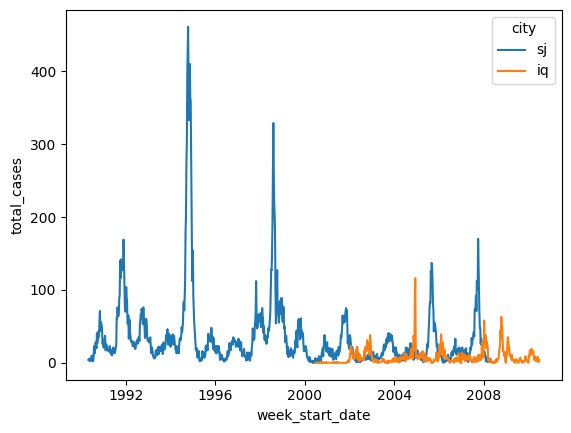

In [6]:
train_features_temp = pd.read_csv(datapath+'/dengue_features_train.csv')
train_labels_temp = pd.read_csv(datapath+'/dengue_labels_train.csv')
train_labels_temp['week_start_date'] = pd.to_datetime(train_features_temp['week_start_date'])
sns.lineplot(train_labels_temp,x='week_start_date',y='total_cases',hue='city');

## Helpers

The helper functions required to replicate the solution is compiled below for convenience, including:
- `preprocess` - preprocesses dataset based on user requirements into format suitable for training with XGBoost model
- `create_XGBmodel` - creates XGBoost model
- `modelfit` - fits XGBoost model
- `get_predictions` - performs forecasting sequentially, updating later lagged target values with currently predicted target value.
- `eval_and_plot` - evaluates trained model using both train and validation sets and optionally plots predicted vs ground truth.

The relevant features of the functions will be elaborated in the following sections.

In [7]:
def preprocess(df_features_or: pd.DataFrame,
               labels=None,
               features_to_keep: Optional[Iterable[str]] = None,
               lagged_features: Optional[Union[Iterable[str],Dict[str, Iterable[str]]]] = None,
               fillna: Optional[str] = None,
               smooth_feat: Optional[int] = None,
               circular_weekofyear: Optional[Union[int, Iterable[pd.DataFrame]]] = None,
               weekofyear_shift = 0,
               feature_lags=None,
               label_lags=None):
    '''
    Perform basic preprocessing and add lagged features or target values as needed, accounting for existence of two cities in dataset.
    df_features_or: Dataframe providing features
    labels: Target values with same size as df_features
    features_to_keep: Iterable of features to use for current model. Exclude features that should be dropped.
    lagged_features: None to not used lagged features. Otherwise provide iterable of feature names to add lags as specified in feature_lags. Alternative, provide dictionary of feature_name: lags pair to create customized lags for each feature
    fillna: Fill NaN approach, e.g. 'ffill'. None to not fill.
    smooth_feat: Provide odd integer of filter window to peform median filtering on features before model building
    circular_weekofyear: Pick weekofyear encoding approach. None: do nothing, 0: inverted U, 1: sine + cosine, 2: inverted sine, 3: target encoding, Iterable[df,df]: prefitted target encoder, to transform here.
    feature_lags: Iterable of lags to consider for features, 
    '''

    # Function to shift target-encoded weekofyear with wrapping around
    def get_shift_weekofyear(df, steps):
        length = len(df)
        df = pd.concat([df,df],axis=0)
        df['weekofyear_targenc'] = df['weekofyear_targenc'].shift(-steps)
        df = df.iloc[steps+1:steps+length+1,:]
        df.sort_values('weekofyear',inplace=True)
        return df

    df_features = df_features_or.copy()
    df_features = df_features.reset_index()

    if features_to_keep is not None:         # Filter features
        feature_names = features_to_keep + ['city']
        df_features = df_features[feature_names]
    else:
        feature_names = list(df_features.columns)

    if fillna is not None:                   # Fill NaNs
        df_features.fillna(method=fillna, inplace=True)

    # Convert city feature to categorical and one hot encode
    df_features["city"] = df_features["city"].astype("category")
    df_features = pd.get_dummies(df_features, columns=['city'], drop_first=True)

    # Split cities before adding lags
    sj_features = df_features[df_features['city_sj']]
    iq_features = df_features[~df_features['city_sj']]

    if labels is not None:
        sj_labels = labels[df_features['city_sj']]
        iq_labels = labels[~df_features['city_sj']]
    else:
        sj_labels = None        
        iq_labels = None

    # Create circular week of year.
    if circular_weekofyear is not None:
        if isinstance(circular_weekofyear,int):
            if circular_weekofyear == 0:     # Inverted U-shape
                sj_features['weekofyear'] = np.sin((sj_features['weekofyear']-1-weekofyear_shift)/51*np.pi)    # Method 1
                iq_features['weekofyear'] = np.sin((iq_features['weekofyear']-1-weekofyear_shift)/51*np.pi)    # Method 1
            elif circular_weekofyear == 1:   # Sine and cosine curves to give unique representations
                sj_features['weekofyear1'] = np.cos((sj_features['weekofyear']-1-weekofyear_shift)/51*2*np.pi)
                sj_features['weekofyear2'] = np.cos((sj_features['weekofyear']-1-weekofyear_shift)/51*2*np.pi)
                sj_features.drop(columns=['weekofyear'],inplace=True)
                iq_features['weekofyear1'] = np.cos((iq_features['weekofyear']-1-weekofyear_shift)/51*2*np.pi)
                iq_features['weekofyear2'] = np.cos((iq_features['weekofyear']-1-weekofyear_shift)/51*2*np.pi)
                iq_features.drop(columns=['weekofyear'],inplace=True)
            elif circular_weekofyear == 2:   # Inverted sine curve for San Juan pattern
                sj_features['weekofyear'] = -np.sin((sj_features['weekofyear']-1-weekofyear_shift)/51*2*np.pi)   # Method 3
                iq_features['weekofyear'] = -np.sin((iq_features['weekofyear']-1-weekofyear_shift)/51*2*np.pi)   # Method 3
            elif circular_weekofyear == 3:   # Target encoding, fit transform
                # Fit
                sj_targenc_woy = pd.concat([sj_features[['weekofyear']],sj_labels],axis=1).groupby('weekofyear').mean().reset_index()
                sj_targenc_woy.rename(columns={'total_cases':'weekofyear_targenc'},inplace=True)
                iq_targenc_woy = pd.concat([iq_features[['weekofyear']],iq_labels],axis=1).groupby('weekofyear').mean().reset_index()
                iq_targenc_woy.rename(columns={'total_cases':'weekofyear_targenc'},inplace=True)
                # Shift if needed
                shifted_sj_targenc_woy = get_shift_weekofyear(sj_targenc_woy, weekofyear_shift)
                shifted_iq_targenc_woy = get_shift_weekofyear(iq_targenc_woy, weekofyear_shift)
                # Transform
                sj_features = sj_features.merge(shifted_sj_targenc_woy,how='left',on='weekofyear')
                sj_features.drop(columns=['weekofyear'],inplace=True)
                iq_features = iq_features.merge(shifted_iq_targenc_woy,how='left',on='weekofyear')
                iq_features.drop(columns=['weekofyear'],inplace=True)
            elif circular_weekofyear == 4: # U-shape for Iquitos pattern
                sj_features['weekofyear'] = -np.sin((sj_features['weekofyear']-1)/51*np.pi)    # Method 1
                iq_features['weekofyear'] = -np.sin((iq_features['weekofyear']-1)/51*np.pi)    # Method 1


        elif isinstance(circular_weekofyear,Iterable): # Transform if target encoding supplied
            assert len(circular_weekofyear)==2, "circular_weekofyear should contain exactly two dataframes, one for sja nd one for iq"
            sj_targenc_woy, iq_targenc_woy = circular_weekofyear
            # Shift if needed
            shifted_sj_targenc_woy = get_shift_weekofyear(sj_targenc_woy, weekofyear_shift)
            shifted_iq_targenc_woy = get_shift_weekofyear(iq_targenc_woy, weekofyear_shift)
            # Transform
            sj_features = sj_features.merge(shifted_sj_targenc_woy,how='left',on='weekofyear')
            sj_features.drop(columns=['weekofyear'],inplace=True)
            iq_features = iq_features.merge(shifted_iq_targenc_woy,how='left',on='weekofyear')
            iq_features.drop(columns=['weekofyear'],inplace=True)

    # Add smoothing to features
    if smooth_feat is not None:
        features_no_woy_city = [col for col in sj_features.columns if not (col in ['weekofyear','weekofyear_targenc','weekofyear1','weekofyear2','city_sj'])]
        sj_features[features_no_woy_city] = sj_features[features_no_woy_city].apply(lambda col: medfilt(col, kernel_size=smooth_feat))
        iq_features[features_no_woy_city] = iq_features[features_no_woy_city].apply(lambda col: medfilt(col, kernel_size=smooth_feat))

    # Lagged feature/labels creation
    if (lagged_features is not None) or (label_lags is not None):
        # Add lagged features
        if isinstance(lagged_features,dict):                # Do individual lags for different features
            for feat, feat_lags in lagged_features.items():
                sj_features_lagged = sj_features[feat].shift(periods=feat_lags)
                sj_features = pd.concat([sj_features,sj_features_lagged],axis=1)
                iq_features_lagged = iq_features[feat].shift(periods=feat_lags)
                iq_features = pd.concat([iq_features,iq_features_lagged],axis=1)
        elif isinstance(lagged_features, (list, tuple)):    # All considered features has same lags
            for feat in lagged_features:
                if 'total_cases' in feat:                   # Skip all total_cases features, used when preprocessing pred features
                    continue
                sj_features_lagged = sj_features[feat].shift(periods=feature_lags)
                sj_features = pd.concat([sj_features,sj_features_lagged],axis=1)
                iq_features_lagged = iq_features[feat].shift(periods=feature_lags)
                iq_features = pd.concat([iq_features,iq_features_lagged],axis=1)

        # Add lagged labels
        if label_lags is not None:
            sj_lagged_labels = sj_labels.shift(periods=label_lags)
            sj_features = pd.concat([sj_features,sj_lagged_labels],axis=1)
            iq_lagged_labels = iq_labels.shift(periods=label_lags)
            iq_features = pd.concat([iq_features,iq_lagged_labels],axis=1)

    if circular_weekofyear == 3:
        return sj_features, iq_features, sj_labels, iq_labels, sj_targenc_woy, iq_targenc_woy
    else:
        return sj_features, iq_features, sj_labels, iq_labels

def create_XGBmodel(eta=0.01,n_estimators=1000,
                    max_depth=5,objective='reg:squarederror',
                    min_child_weight=1.02, gamma=0.51, subsample=0.86,
                    colsample_bytree=0.84, scale_pos_weight=1, seed=42,
                    **kwargs):
    '''
    Create an XGBRegressor model based on availability of GPU
    '''

    try:
        cuda.detect()
        gpu_available = cuda.is_available()
    except:
        gpu_available = False

    if gpu_available:
        return xgb.XGBRegressor(
            tree_method= 'gpu_hist',  # Use GPU accelerated algorithm
            n_gpus=1,
            device='cuda:0',
            learning_rate =eta,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= objective,
            scale_pos_weight=scale_pos_weight,
            seed=seed,
            **kwargs)
    else:
        return xgb.XGBRegressor(
            learning_rate =eta,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= objective,
            scale_pos_weight=scale_pos_weight,
            seed=seed,
            **kwargs)
    
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50,trainCV_metrics = 'mae',
             eval_metric = 'mae',report_metric =  metrics.mean_absolute_error, verbose=True,
             weights=None, feature_weights = None):
    '''
    Automatically fit model, with option for using CV to get best n_estimators. Adapted from code given in: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    alg: XGBoost model.
    weights: Weights for each data point
    feature_weights: Weights for each feature. Used here to reduce weights on lagged labels to reduce reliance on it.
    '''

    xgb_param = alg.get_xgb_params()

    # Set same feature weights (at 100 for ease of interpretation) throughout by default
    if feature_weights is None:
        feature_weights = 100*np.ones(X_train.shape[1])

    xgtrain = xgb.DMatrix(X_train, label=y_train,feature_weights=feature_weights)
    xgtrain.set_info(feature_weights=feature_weights)

    if weights is not None:
        xgtrain.set_weight(weights)

    if useTrainCV:
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=trainCV_metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, feature_weights=feature_weights)
        
    #Predict training set:
    X_train_predictions = alg.predict(X_train)
        
    #Print model report:
    if verbose:
        print("\nModel Report")
        print(report_metric)
        print(report_metric(y_train, X_train_predictions))

def get_predictions(model, X_val,
                    label_lags: Optional[Iterable[int]]=None):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Trained XGBoost Regressor model
    X_val: Validation features
    label_lags: Label lags, None to signify no lagged labels used
    '''

    if label_lags is not None:
        X_val_no_lags = X_val.copy()
        lag_label_col_names = ['total_cases_'+str(lag) for lag in label_lags]                     # Lagged label names
        lag_label_col_locs = [X_val_no_lags.columns.get_loc(col) for col in lag_label_col_names]  # Get locations of lagged labels

        pred_val = np.zeros(X_val_no_lags.shape[0])
        for i in range(X_val_no_lags.shape[0]):
            pred_val[i] = model.predict(X_val_no_lags.iloc[i:i+1,:])                    # Predict current value, keep input in required dataframe format
            for k,j in enumerate(label_lags):                                           # Add predicted value to X_val as lagged labels for subsequent rows
                try:
                    X_val_no_lags.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
                except:
                    continue
    else:
        pred_val = model.predict(X_val)
    pred_val = np.round(pred_val)
    pred_val = np.clip(pred_val, 0, 10000000)
    
    return pred_val

def eval_and_plot(model,X_train_all,y_train_all,X_val_all,y_val_all,
                  label_lags=None,
                  plot=True,verbose=True, get_pred_train=True,
                  two_cities=False, median_filter: Optional[int]=None,
                  plot_title_header: Optional[str]=None):
    '''
    Evaluate by predicting validation set and optionally plotting
    X_train_all: Dataframe of train features. Iterable of two dataframes if two_cities is True
    y_train_all: Dataframe of train labels. Iterable of two dataframes if two_cities is True
    X_val_all: Dataframe of val features. Iterable of two dataframes if two_cities is True
    y_val_all: Dataframe of val labels. Iterable of two dataframes if two_cities is True
    get_pred_train: True to calculate using previously predicted labels as lagged labels
    two_cities: Training model on both cities, requires splitting.
    median_filter: Apply median filtering to results.
    plot_title_header: Header for plot title
    '''

    if plot_title_header is None:
        plot_title_header = ''

    # If both cities trained together, input should be iterable of two datasets
    if two_cities:
        assert len(X_train_all)==2
        assert len(y_train_all)==2
        assert len(X_val_all)==2
        assert len(y_val_all)==2
    else:
        X_train_all = [X_train_all]
        y_train_all = [y_train_all]
        X_val_all = [X_val_all]
        y_val_all = [y_val_all]

    # Collect values separately for each city
    pred_train_all = []
    pred_val_all = []
    train_mae_all = []
    val_mae_all = []

    for X_train, y_train, X_val, y_val in zip(X_train_all, y_train_all, X_val_all, y_val_all):
        # Get predicted train values
        if get_pred_train:
            pred_train = get_predictions(model, X_train, label_lags)
        else:
            pred_train = model.predict(X_train)

        if median_filter is not None:
            pred_train = medfilt(pred_train,median_filter)

        pred_train = np.round(pred_train)
        pred_train = np.clip(pred_train, 0, 10000000)
        
        train_mae = mean_absolute_error(y_train, pred_train)
        if verbose:
            print("Train MAE:", train_mae)

        # Get prediction validation values
        pred_val = get_predictions(model, X_val, label_lags)

        if median_filter is not None:
            pred_val = medfilt(pred_val,median_filter)

        val_mae = mean_absolute_error(y_val, pred_val)
        if verbose:
            print("Val MAE:", val_mae)
        
        pred_train_all.append(pred_train)
        pred_val_all.append(pred_val)
        train_mae_all.append(train_mae)
        val_mae_all.append(val_mae)

    if plot:
        for pred_train, pred_val, y_train, y_val, train_mae, val_mae in zip(pred_train_all, pred_val_all,y_train_all, y_val_all, train_mae_all, val_mae_all):
            # fig, axs = plt.subplots(1,2,figsize=(8,2))
            fig2, axs2 = plt.subplots(2,1,figsize=(10,4))
            # axs[0].scatter(y_train, pred_train)
            pred_train = pd.Series(pred_train, index=y_train.index)
            axs2[0].plot(np.arange(len(pred_train)), pred_train.sort_index(),marker='.',label='pred');
            axs2[0].plot(np.arange(len(y_train)), y_train.sort_index(),marker='.',label='y');
            axs2[0].legend();
            axs2[0].set_title(f'{plot_title_header}Training MAE: {train_mae}')

            # axs[1].scatter(y_val, pred_val)
            pred_val = pd.Series(pred_val, index=y_val.index)
            axs2[1].plot(np.arange(len(pred_val)), pred_val.sort_index(),marker='.',label='pred');
            axs2[1].plot(np.arange(len(y_val)), y_val.sort_index(),marker='.',label='y');
            axs2[1].legend();
            axs2[1].set_title(f'{plot_title_header}Validation MAE: {val_mae}')
            
            # fig.tight_layout()
            fig2.tight_layout()
            
        if not two_cities: # Unpacking directly if individually trained
            pred_train_all, pred_val_all, train_mae_all, val_mae_all = pred_train_all[0], pred_val_all[0], train_mae_all[0], val_mae_all[0]

    return pred_train_all, pred_val_all, train_mae_all, val_mae_all

## Illustration of Multi-step Forecasting Difficulties

To illustrate the issue with multi-step forecasting when using XGBoost, we first construct a simple XGBoost model. We train the model on the San Juan data and evaluate its performance on multiple folds, using lags of 1 to 5 for both the features and the target.

__Train data:__ We first consider prediction on train data _without_ accounting for multi-step forecasting issues described in [Approach](#Approach). This is done by setting `get_pred_train=False` in the call to `eval_and_plot`. The train MAE and plotted prediction values are obtained simply through the predict method in this case.

__Validation dataset:__ The validation predictions are obtained using the `get_predictions` function by default, which iteratively updates the lagged target values of later timesteps with the predicted values of the current timestep.


 ~~~~~~~~~~~~~~ Running fold 1 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported

 ~~~~~~~~~~~~~~ Running fold 2 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are su

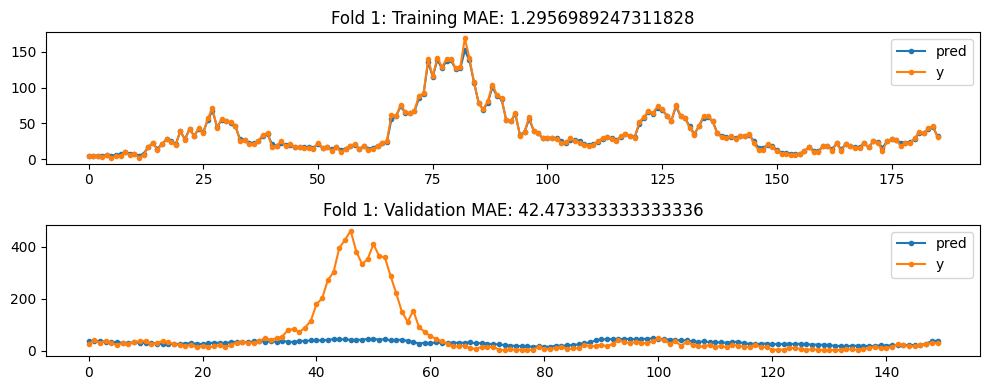

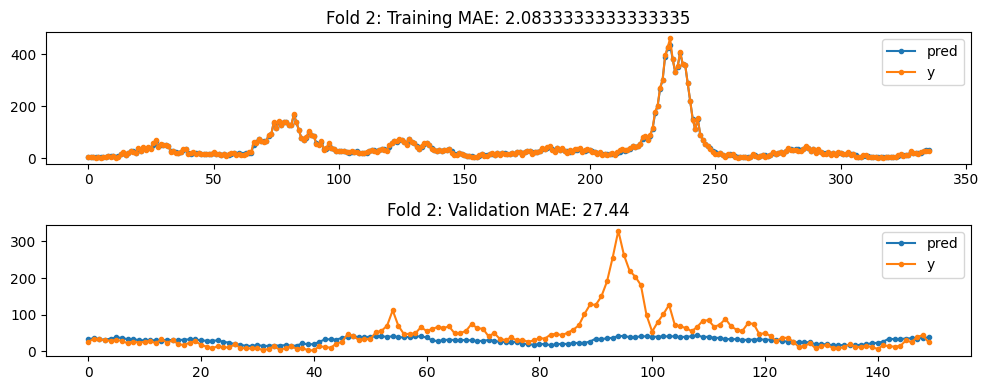

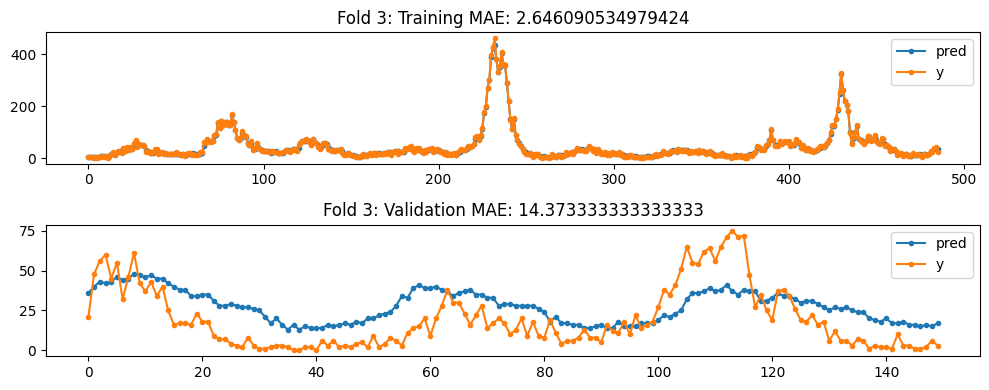

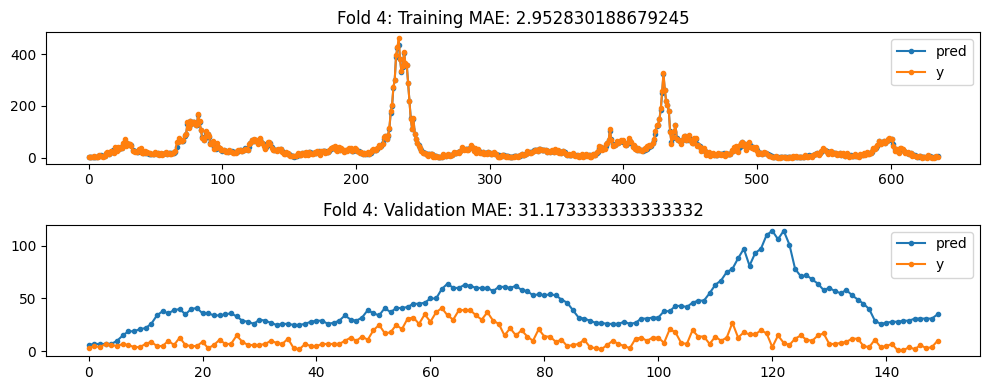

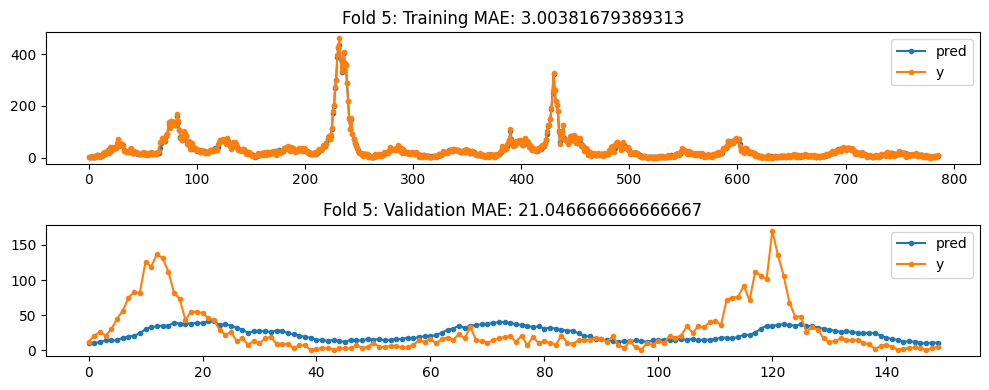

In [8]:
# Lag configuration
label_lags=(1,2,3,4,5)
feature_lags=(1,2,3,4,5)
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']

# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_feature_names,   # Column names of features to create lagged values for
                                                            feature_lags = feature_lags,              # Lags to consider for lagged features
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=None)                 # No encoding for weekofyear
sj_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Use time series split to create train-val sets
X_train_sj, X_val_sj, y_train_sj, y_val_sj = [],[],[],[]
tscv = TimeSeriesSplit(n_splits=5,test_size=150)
for i, (train_index, test_index) in enumerate(tscv.split(sj_features)):
    X_train_sj.append(sj_features.iloc[train_index,:])
    X_val_sj.append(sj_features.iloc[test_index,:])
    y_train_sj.append(sj_labels.iloc[train_index,:])
    y_val_sj.append(sj_labels.iloc[test_index,:])

# Evaluating and plotting over multiple folds
folds = len(X_train_sj)
xg_reg_sj = []
for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    xg_reg_sj.append(create_XGBmodel(
        eta=eta,n_estimators=n_estimators,max_depth=max_depth,          # Creating and storing XGBoost models trained for each fold
        objective='reg:squarederror',
        reg_alpha=reg_alpha,reg_lambda=reg_lambda))

    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],       # Use modelfit function to use CV for selecting best n_estimators
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False)
    pred_train_sj, pred_val_sj,\
    train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold].sort_index(),y_train_sj[fold].sort_index(),
                                             X_val_sj[fold],y_val_sj[fold],
                                             verbose=False,plot=True,
                                             label_lags = label_lags,
                                             get_pred_train=False,      # Deactivate sequential prediction approach for multi-step forecasting
                                             plot_title_header=f'Fold {fold+1}: '
                                             )

As shown, the model predicts the training target values very well in every fold, capturing every peak almost perfectly. This performance is misleading due to the assumption of perfect knowledge of lagged target values. As shown below, we can make use of the `get_predictions` function for the training data too, activated through `get_pred_train=True` in `eval_and_plot`.


 ~~~~~~~~~~~~~~ Running fold 1 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported

 ~~~~~~~~~~~~~~ Running fold 2 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are su

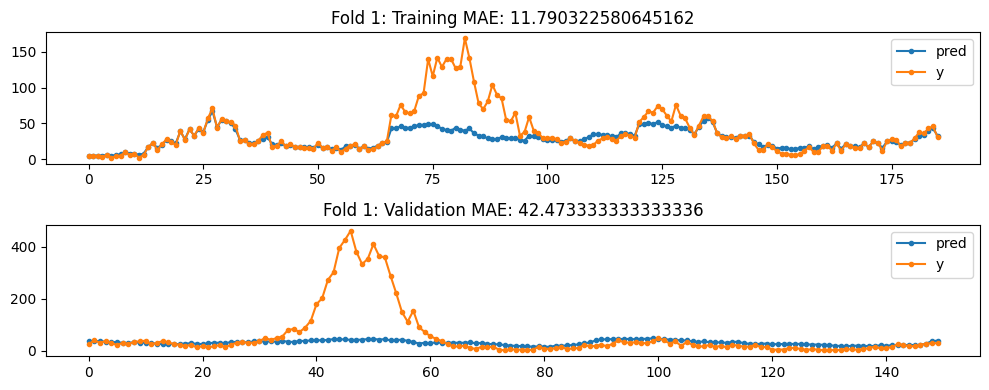

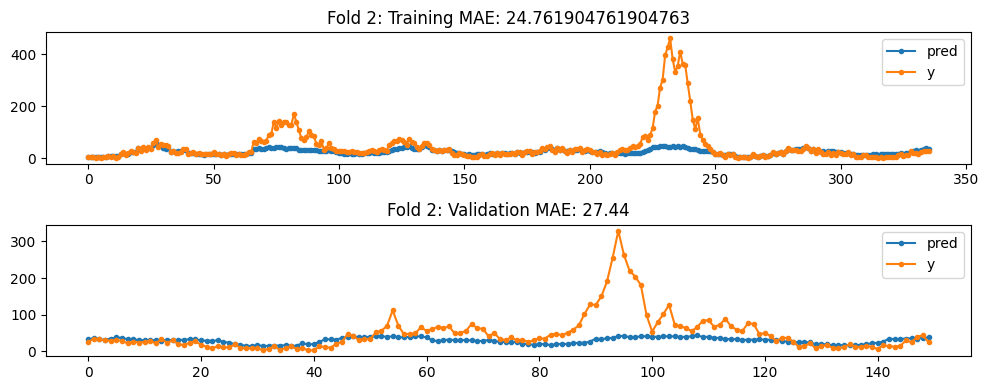

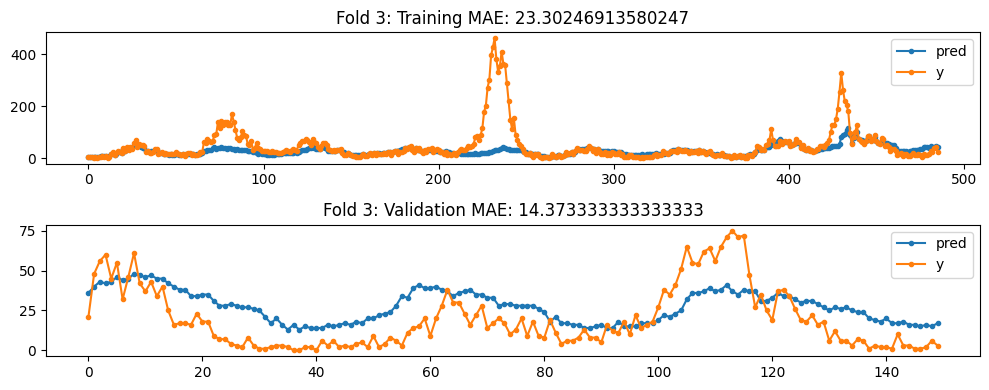

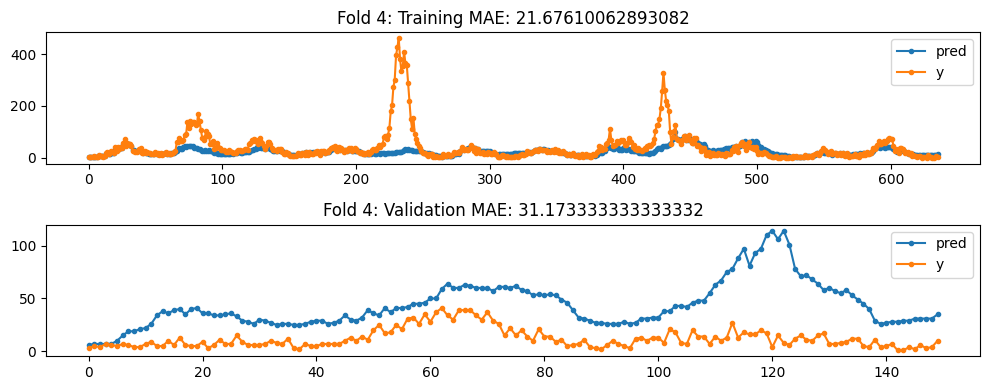

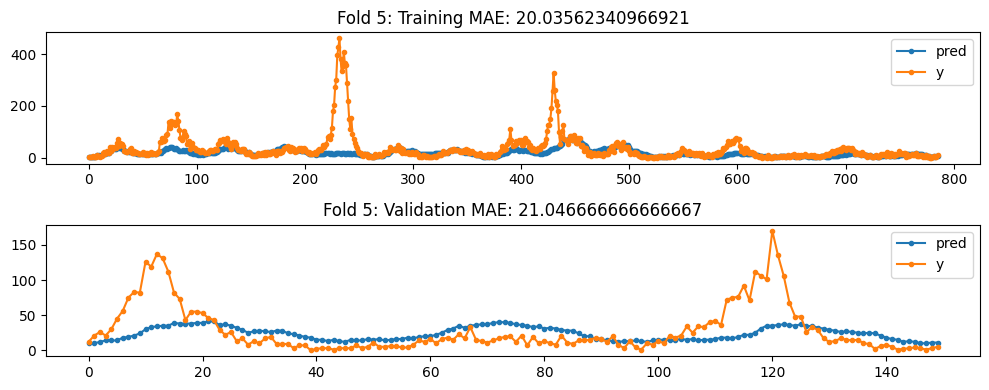

In [9]:
# Lag configuration
label_lags=(1,2,3,4,5)
feature_lags=(1,2,3,4,5)
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']

# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_feature_names,   # Column names of features to create lagged values for
                                                            feature_lags = feature_lags,              # Lags to consider for lagged features
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=None)                 # No encoding for weekofyear
sj_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Use time series split for train-val sets
X_train_sj, X_val_sj, y_train_sj, y_val_sj = [],[],[],[]
tscv = TimeSeriesSplit(n_splits=5,test_size=150)
for i, (train_index, test_index) in enumerate(tscv.split(sj_features)):
    X_train_sj.append(sj_features.iloc[train_index,:])
    X_val_sj.append(sj_features.iloc[test_index,:])
    y_train_sj.append(sj_labels.iloc[train_index,:])
    y_val_sj.append(sj_labels.iloc[test_index,:])

# Evaluating and plotting over multiple folds
folds = len(X_train_sj)
xg_reg_sj = []
for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    xg_reg_sj.append(create_XGBmodel(
        eta=eta,n_estimators=n_estimators,max_depth=max_depth,          # Creating and storing XGBoost models trained for each fold
        objective='reg:squarederror',
        reg_alpha=reg_alpha,reg_lambda=reg_lambda))

    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],       # Use modelfit function to use CV for selecting best n_estimators
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False)
    pred_train_sj, pred_val_sj,\
    train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold].sort_index(),y_train_sj[fold].sort_index(),
                                             X_val_sj[fold],y_val_sj[fold],
                                             verbose=False,plot=True,
                                             label_lags = label_lags,
                                             get_pred_train=True,      # Activate sequential prediction approach for multi-step forecasting
                                             plot_title_header=f'Fold {fold+1}: '
                                             )

The train scores deteriorate rapidly, indicating that the model is trained to over-rely on the lagged target values, the precise value of which will not be available in the test set. Therefore, the model training and parameter selection performed herein account for this effect and consistently make use of the `get_predictions` function when evaluating train score.

## Lagged Target Paradox

For time series modelling, the lagged target values play an important role. We visualize this with a plot of feature importance for the model trained previously.

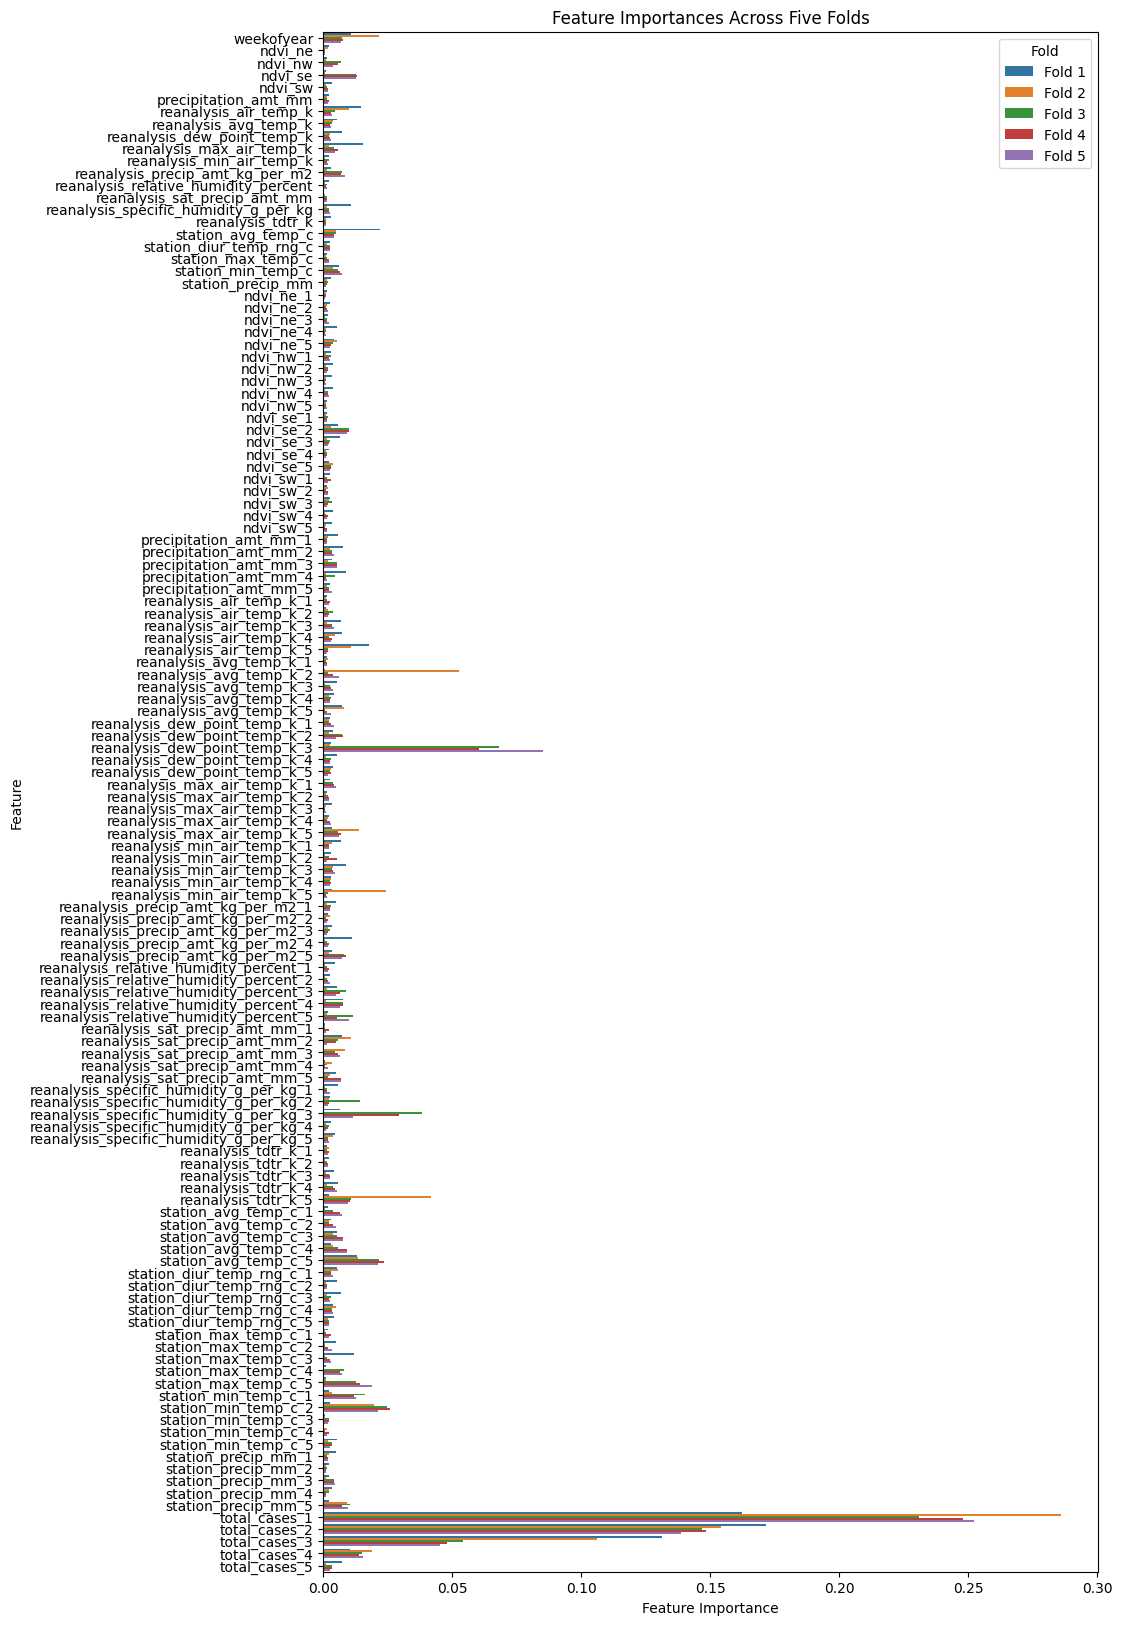

In [10]:
# Get feature importances for each fold and prepare the data in long format
data = []
num_folds = 5
for fold in range(num_folds):
    importances = xg_reg_sj[fold].feature_importances_
    features = X_train_sj[fold].columns
    for feat, imp in zip(features, importances):
        data.append({'Feature': feat, 'Importance': imp, 'Fold': f'Fold {fold+1}'})
df = pd.DataFrame(data) # Convert the data into a DataFrame

# Create a grouped bar plot
plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', hue='Fold', data=df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Across Five Folds')
plt.legend(title='Fold');

As shown in the feature importance plot, the first two lagged target variables (`total_cases_1` and `total_cases_2`) are overwhelmingly used in prediction. For multi-step forecasting with XGBoost, such an over-reliance on lagged target values virtually guarantees inferior predictions &mdash; lagged_target values are not known a priori, especially for later timesteps in the sequence. However, such lagged values are valuable and should not be discarded altogether. For the task at hand, we find that applying target/label lags of only (3,4), as opposed to the full range of (1,2,3,4,5), results in a better predictive performance.

From this point, we also apply median filtering with a 3-week window to the output to produce more stable predictions and weed out unrealistic spikes. This is done through `median_filter=3` to the `eval_and_plot` function.


 ~~~~~~~~~~~~~~ Running fold 1 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported

 ~~~~~~~~~~~~~~ Running fold 2 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are su

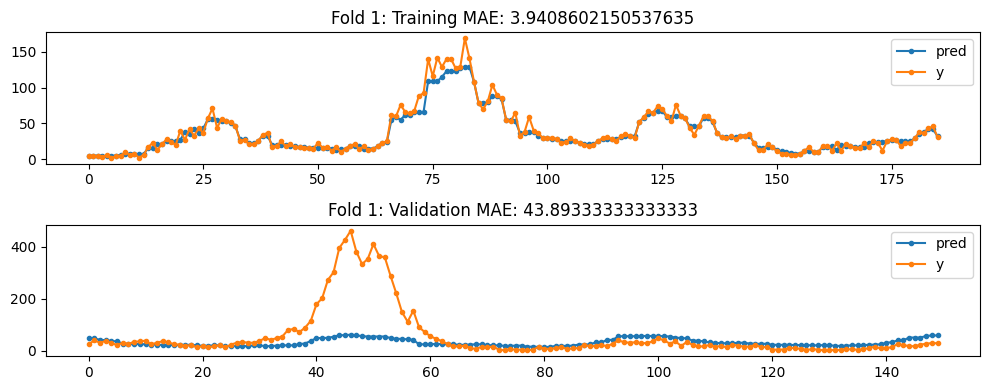

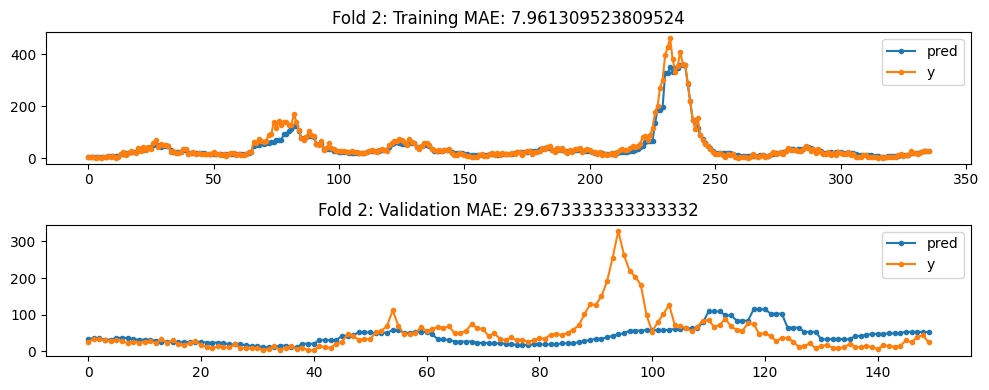

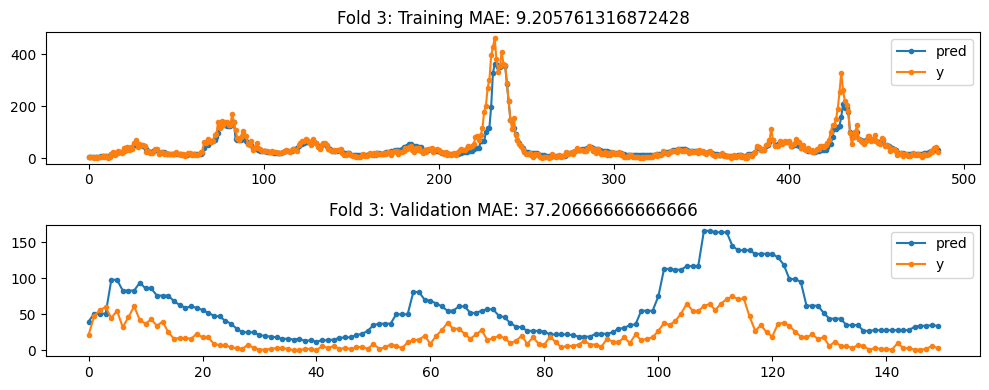

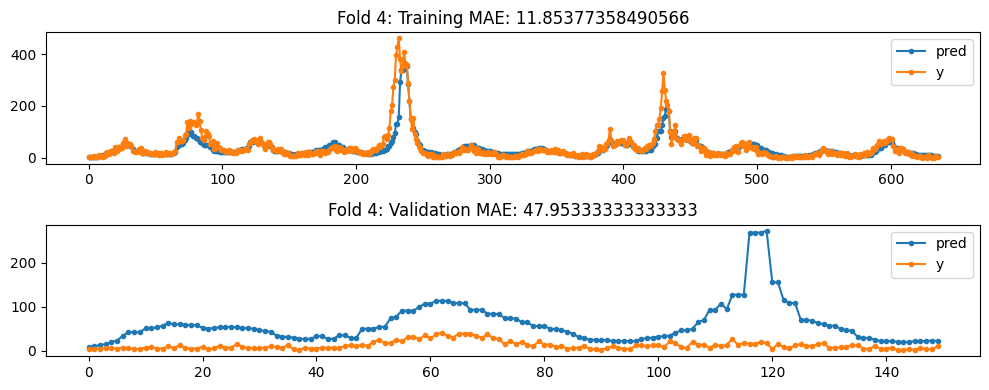

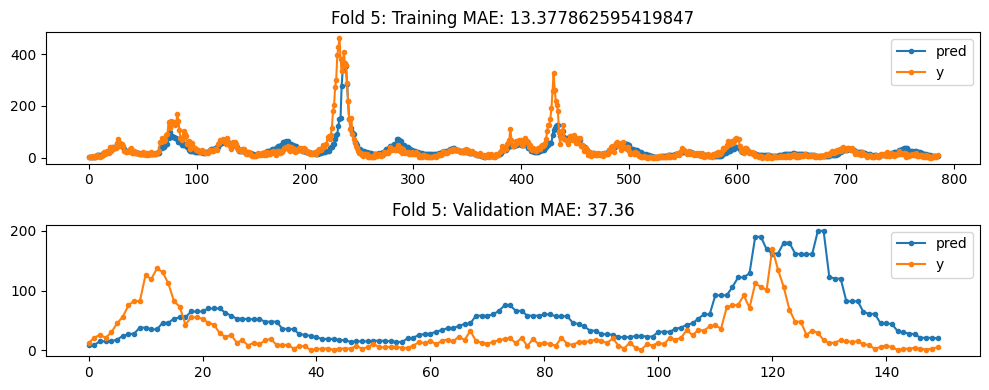

In [11]:
# Lag configuration
label_lags=(3,4)                           # Updated label lags
feature_lags=(1,2,3,4,5)
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']

# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_feature_names,   # Column names of features to create lagged values for
                                                            feature_lags = feature_lags,              # Lags to consider for lagged features
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=None)                 # No encoding for weekofyear
sj_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Use time series split for train-val sets
X_train_sj, X_val_sj, y_train_sj, y_val_sj = [],[],[],[]
tscv = TimeSeriesSplit(n_splits=5,test_size=150)
for i, (train_index, test_index) in enumerate(tscv.split(sj_features)):
    X_train_sj.append(sj_features.iloc[train_index,:])
    X_val_sj.append(sj_features.iloc[test_index,:])
    y_train_sj.append(sj_labels.iloc[train_index,:])
    y_val_sj.append(sj_labels.iloc[test_index,:])

# Evaluating and plotting over multiple folds
folds = len(X_train_sj)
xg_reg_sj = []
for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    xg_reg_sj.append(create_XGBmodel(
        eta=eta,n_estimators=n_estimators,max_depth=max_depth,          # Creating and storing XGBoost models trained for each fold
        objective='reg:squarederror',
        reg_alpha=reg_alpha,reg_lambda=reg_lambda))

    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],       # Use modelfit function to use CV for selecting best n_estimators
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False)
    pred_train_sj, pred_val_sj,\
    train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold].sort_index(),y_train_sj[fold].sort_index(),
                                             X_val_sj[fold],y_val_sj[fold],
                                             verbose=False,plot=True,
                                             label_lags = label_lags,
                                             get_pred_train=True,       # Activate sequential prediction approach for multi-step forecasting
                                             median_filter=3,           # Median filter output
                                             plot_title_header=f'Fold {fold+1}: '
                                            )

Paradoxically, the train score has improved significantly when using fewer (and farther off) lag values. While the validation score has worsened, we see that the model is able to better capture various trends and fluctuations in dengue cases. We replot the feature importance plot for this case below.

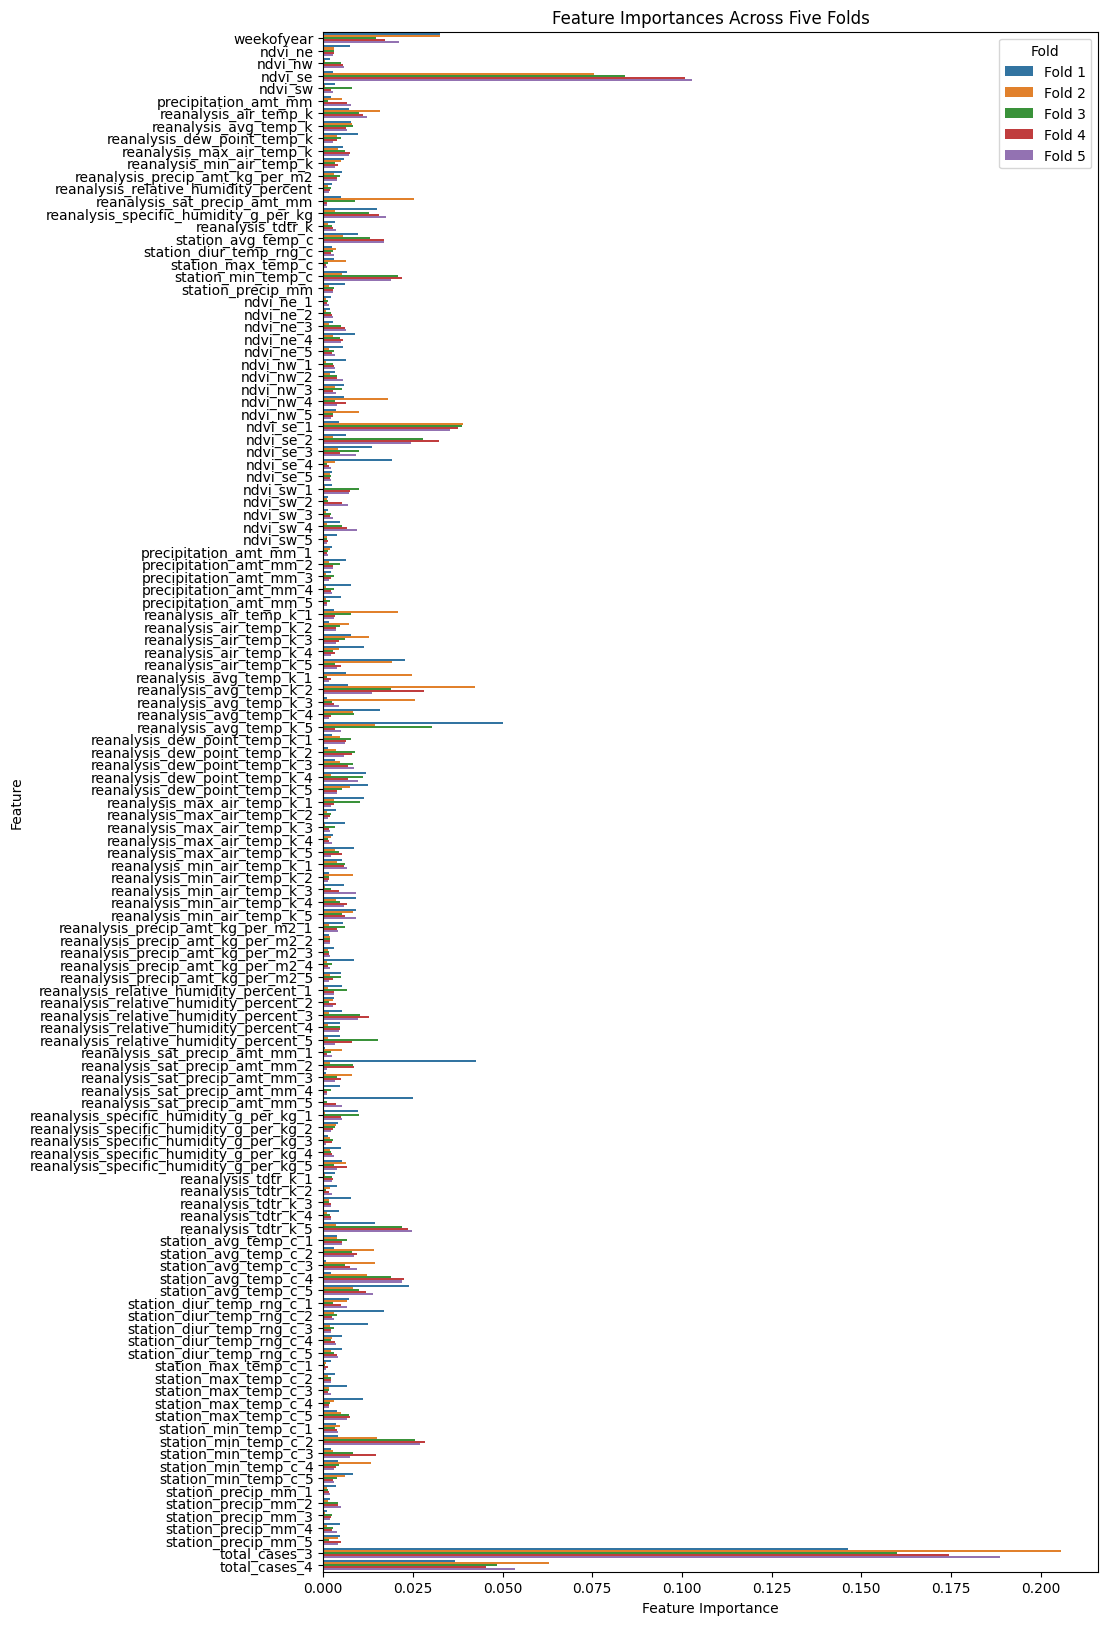

In [12]:
# Get feature importances for each fold and prepare the data in long format
data = []
num_folds = 5
for fold in range(num_folds):
    importances = xg_reg_sj[fold].feature_importances_
    features = X_train_sj[fold].columns
    for feat, imp in zip(features, importances):
        data.append({'Feature': feat, 'Importance': imp, 'Fold': f'Fold {fold+1}'})
df = pd.DataFrame(data) # Convert the data into a DataFrame

# Create a grouped bar plot
plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', hue='Fold', data=df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Across Five Folds')
plt.legend(title='Fold');

We see a decreased reliance on the lagged target variables.

## Feature-Lags

Choosing the appropriate feature lags is also likely to improve model performance. We perform a quick modelling, including multiple feature lags to check the importance score for different features with lags from 1 to 10.


 ~~~~~~~~~~~~~~ Running fold 1 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported

 ~~~~~~~~~~~~~~ Running fold 2 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are su

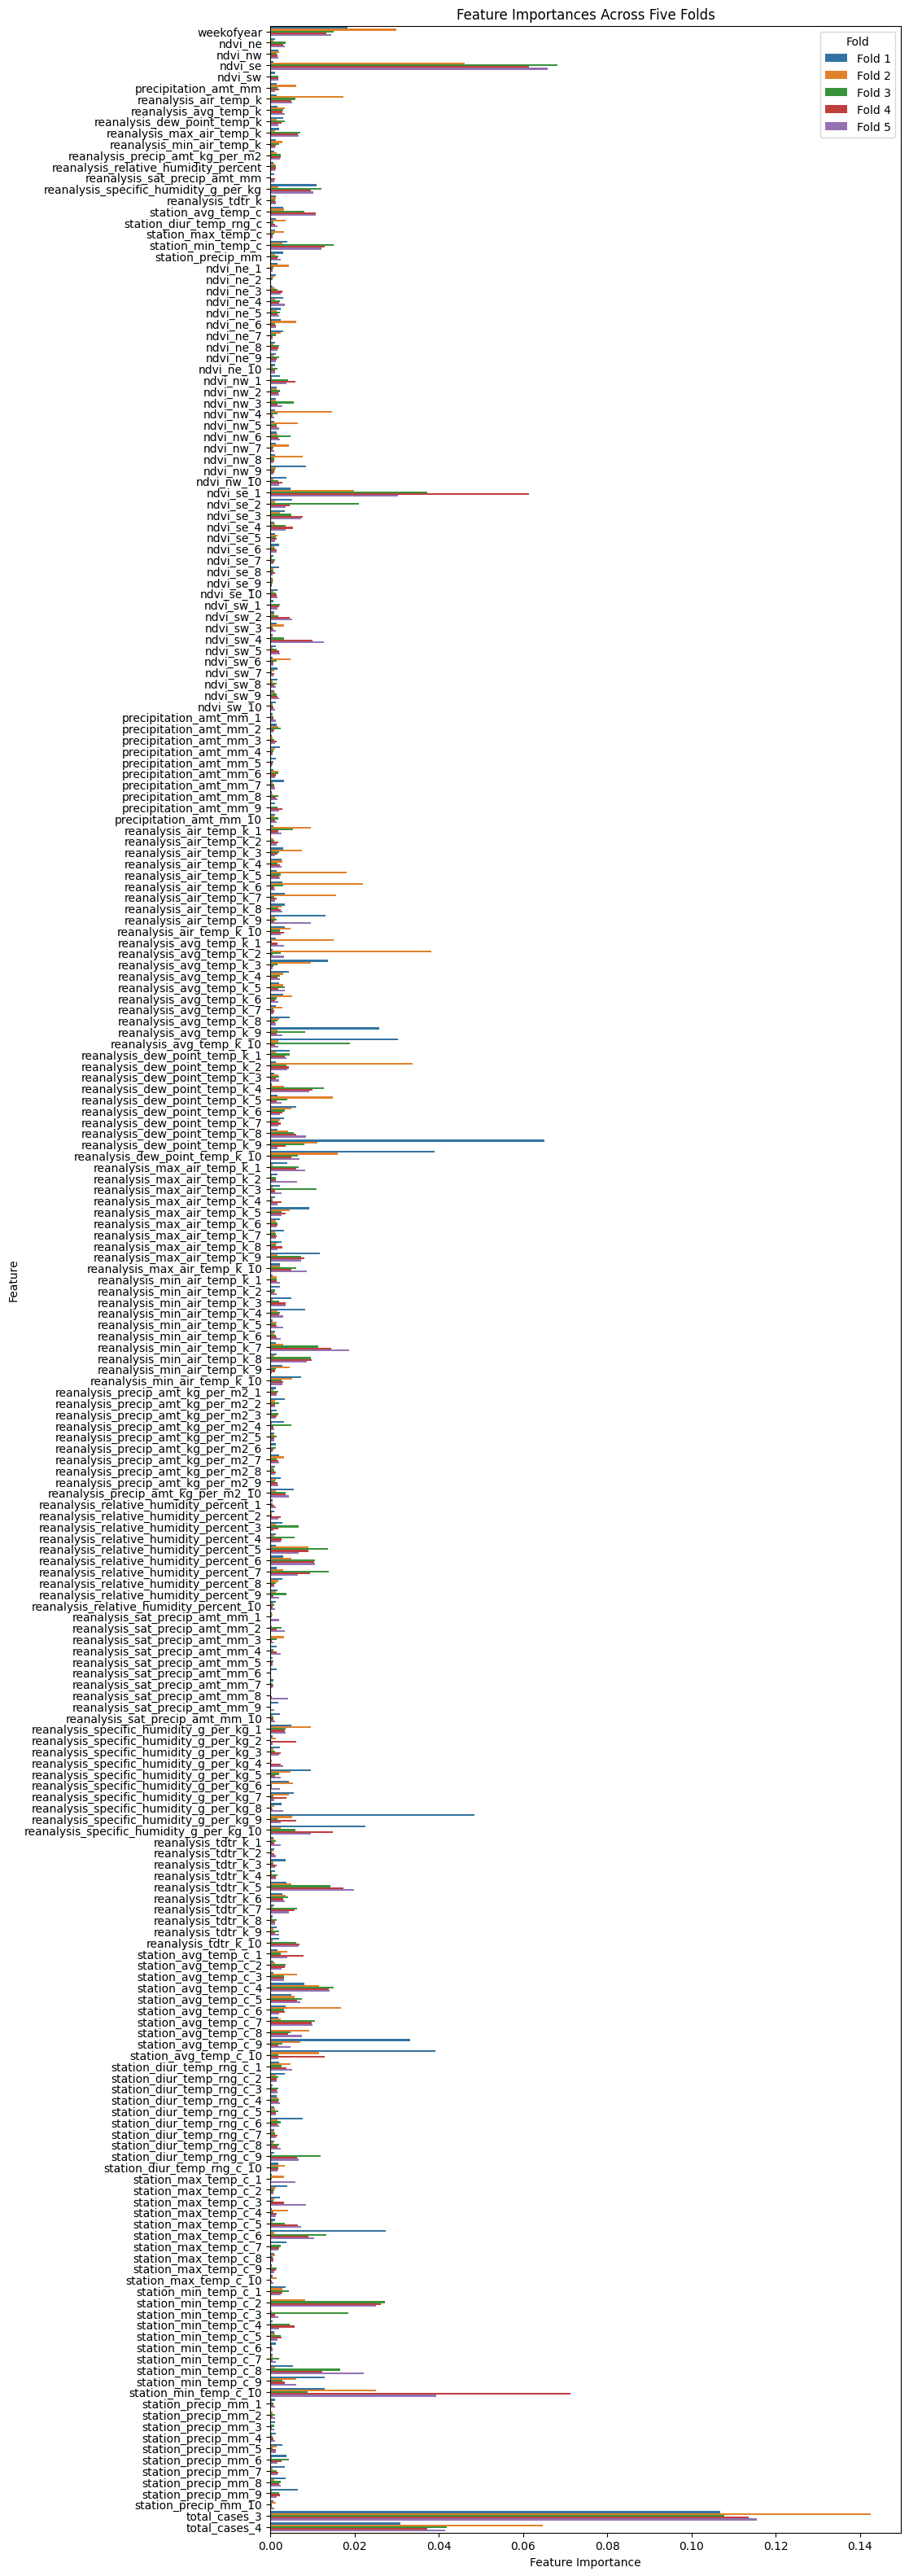

In [13]:
# Lag configuration
label_lags=(3,4)
feature_lags=(1,2,3,4,5,6,7,8,9,10)               # Multiple feature lags to ascertain important lag values
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']

# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_feature_names,   # Column names of features to create lagged values for
                                                            feature_lags = feature_lags,              # Lags to consider for lagged features
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=None)                 # No encoding for weekofyear
sj_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Use time series split for train-val sets
X_train_sj, X_val_sj, y_train_sj, y_val_sj = [],[],[],[]
tscv = TimeSeriesSplit(n_splits=5,test_size=150)
for i, (train_index, test_index) in enumerate(tscv.split(sj_features)):
    X_train_sj.append(sj_features.iloc[train_index,:])
    X_val_sj.append(sj_features.iloc[test_index,:])
    y_train_sj.append(sj_labels.iloc[train_index,:])
    y_val_sj.append(sj_labels.iloc[test_index,:])

# Evaluating and plotting over multiple folds
folds = len(X_train_sj)
xg_reg_sj = []
for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    xg_reg_sj.append(create_XGBmodel(
        eta=eta,n_estimators=n_estimators,max_depth=max_depth,          # Creating and storing XGBoost models trained for each fold
        objective='reg:squarederror',
        reg_alpha=reg_alpha,reg_lambda=reg_lambda))

    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],       # Use modelfit function to use CV for selecting best n_estimators
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False)
    pred_train_sj, pred_val_sj,\
    train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold].sort_index(),y_train_sj[fold].sort_index(),
                                             X_val_sj[fold],y_val_sj[fold],
                                             verbose=False,plot=False,
                                             label_lags = label_lags,
                                             get_pred_train=True,       # Activate sequential prediction approach for multi-step forecasting
                                             median_filter=3,           # Median filter output
                                             plot_title_header=f'Fold {fold+1}: '
                                            )
    
# Get feature importances for each fold and prepare the data in long format
data = []
num_folds = 5
for fold in range(num_folds):
    importances = xg_reg_sj[fold].feature_importances_
    features = X_train_sj[fold].columns
    for feat, imp in zip(features, importances):
        data.append({'Feature': feat, 'Importance': imp, 'Fold': f'Fold {fold+1}'})
df = pd.DataFrame(data) # Convert the data into a DataFrame

# Create a grouped bar plot
plt.figure(figsize=(10, 40))
sns.barplot(x='Importance', y='Feature', hue='Fold', data=df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Across Five Folds')
plt.legend(title='Fold');

Looking at the importance values of the lagged features, we observe that the ndvi features tend to show higher importance in the first three lagged weeks. For weather features, high importance is observed both in the short term (2\~3 week lag) and in the long term (8\~9 week lag). Therefore, we implement only short term lags for former, and both short and long term lags for the latter. This is done by passing the `lagged_features` dictionary to `preprocess`.

Furthermore, to reduce the number of features created from creating weather lags, we apply smoothing to the features over time, applying a 3-week window with a median filter. This is achieved with `smooth_feat=3` in `preprocess`. We then select only lags of 2, 5 and 8 for the weather features, which would contain condensed information over 3 week windows after the smoothing process.


 ~~~~~~~~~~~~~~ Running fold 1 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported

 ~~~~~~~~~~~~~~ Running fold 2 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are su

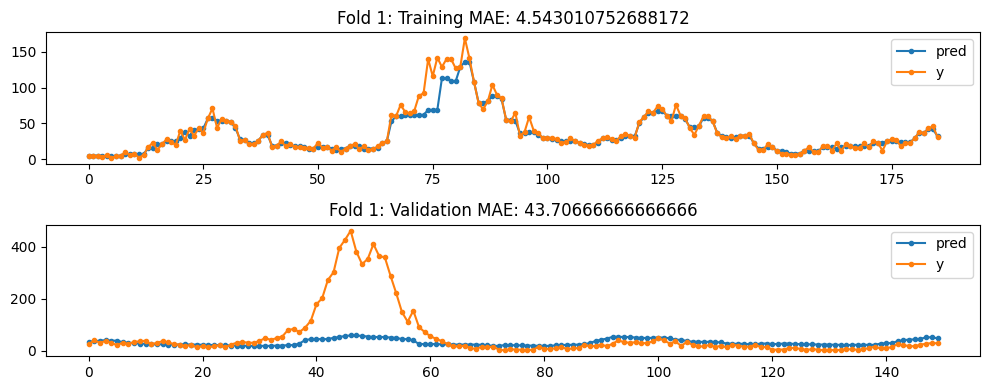

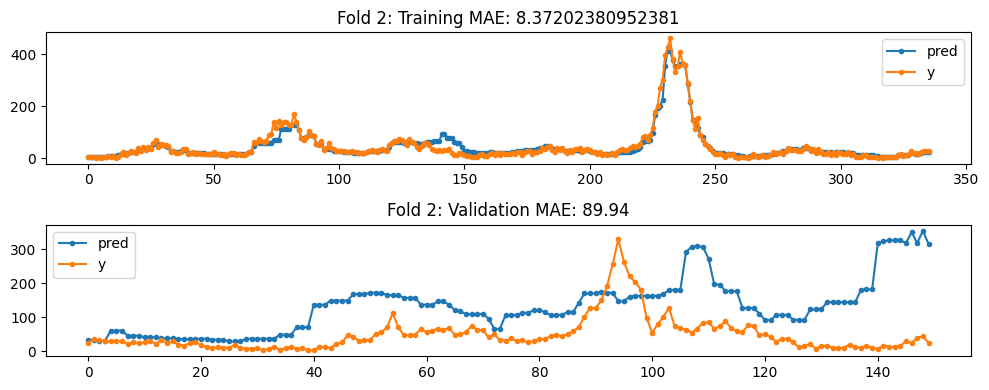

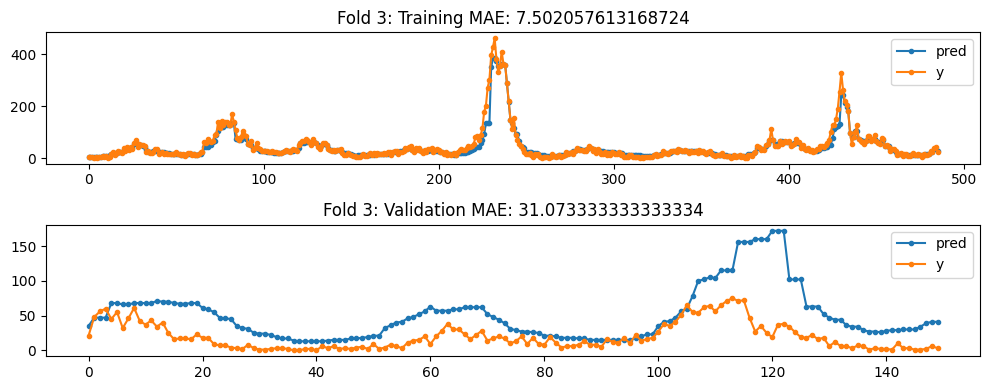

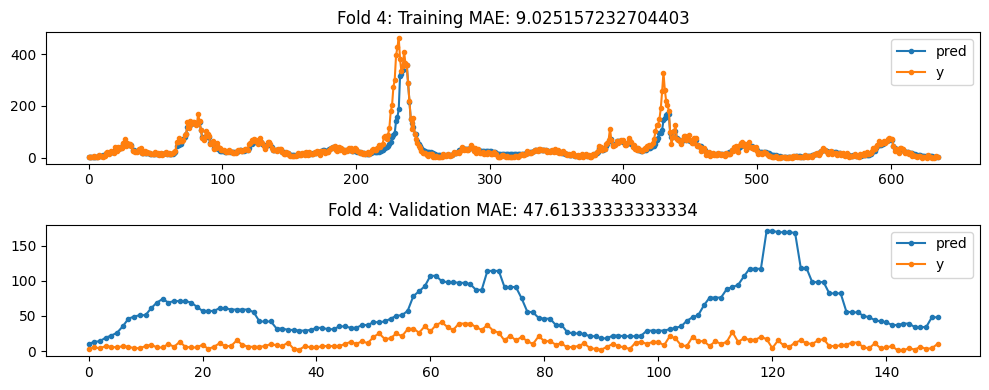

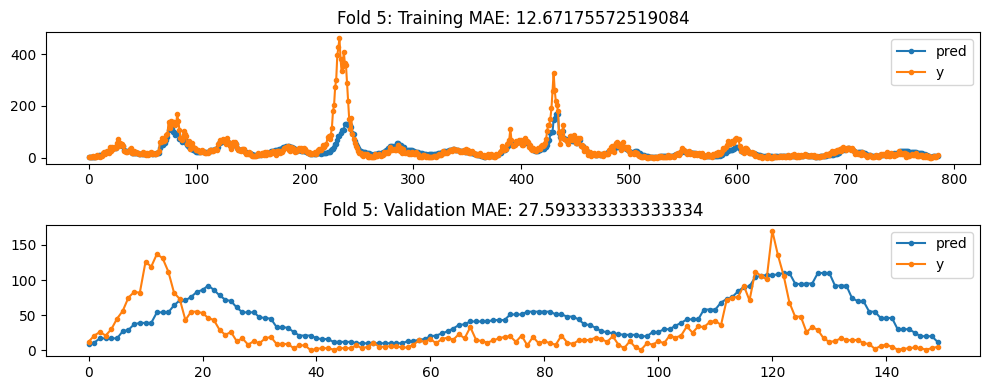

In [14]:
# Custom lag configuration with different lags for different features
label_lags=(3,4)
feature_lags=None
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']
lagged_features = {col:[1,2,3] for col in lagged_feature_names if ('ndvi' in col)}  # (1,2,3) lags for ndvi features
lagged_features_others = {col:(2,5,8) for col in lagged_feature_names if not ('ndvi' in col)} # (2,5,8) lags for weather features
lagged_features.update(lagged_features_others)

# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_features,        # feature_name: lag pairs in dictionary for custom lag configuration
                                                            feature_lags = feature_lags,              # None here, inactive 
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=None,                 # No encoding for weekofyear
                                                            smooth_feat=3)                            # Apply median filtering with 3 week window for features
sj_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Use time series split for train-val sets
X_train_sj, X_val_sj, y_train_sj, y_val_sj = [],[],[],[]
tscv = TimeSeriesSplit(n_splits=5,test_size=150)
for i, (train_index, test_index) in enumerate(tscv.split(sj_features)):
    X_train_sj.append(sj_features.iloc[train_index,:])
    X_val_sj.append(sj_features.iloc[test_index,:])
    y_train_sj.append(sj_labels.iloc[train_index,:])
    y_val_sj.append(sj_labels.iloc[test_index,:])

# Evaluating and plotting over multiple folds
folds = len(X_train_sj)
xg_reg_sj = []
for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    xg_reg_sj.append(create_XGBmodel(
        eta=eta,n_estimators=n_estimators,max_depth=max_depth,          # Creating and storing XGBoost models trained for each fold
        objective='reg:squarederror',
        reg_alpha=reg_alpha,reg_lambda=reg_lambda))

    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],       # Use modelfit function to use CV for selecting best n_estimators
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False)
    pred_train_sj, pred_val_sj,\
    train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold].sort_index(),y_train_sj[fold].sort_index(),
                                             X_val_sj[fold],y_val_sj[fold],
                                             verbose=False,plot=True,
                                             label_lags = label_lags,
                                             get_pred_train=True,        # Activate sequential prediction approach for multi-step forecasting
                                             median_filter=3,            # Median filter output
                                             plot_title_header=f'Fold {fold+1}: '
                                            )

As shown in the validation curves, the trends are now better captured, with more actual peaks detected (fold 2) and previously overestimated peaks (fold 4) lowered. This shows that it is important to capture long term dependencies in weather conditions.

## Week of Year Effect

We examine the distribution of dengue cases over the year as a function of the week of year.

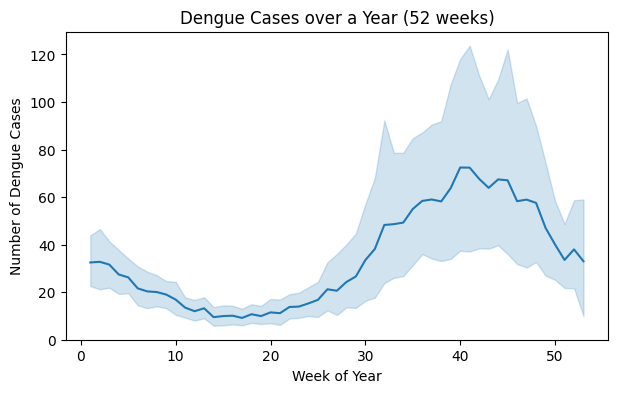

In [15]:
train_labels_temp = pd.read_csv(datapath+'/dengue_labels_train.csv')
fig,ax = plt.subplots(1,1,figsize=(7,4))
sns.lineplot(train_labels_temp[train_labels_temp.city=='sj'],x='weekofyear',y='total_cases',ax=ax)
ax.set_xlabel('Week of Year')
ax.set_ylabel('Number of Dengue Cases')
ax.set_title('Dengue Cases over a Year (52 weeks)');

We see that the number of dengue cases appears to follow predictable patterns over the year, showing an inverted sine curve. We refit the previous model and predict the training targets to see if our predictions show the same trends when compared to ground truth trends.

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported
ERROR! Session/line number was not unique in database. History logging moved to new session 3


Text(0.5, 1.0, 'Train Data Yearly Fit, Ground Truth Compared to Predicted')

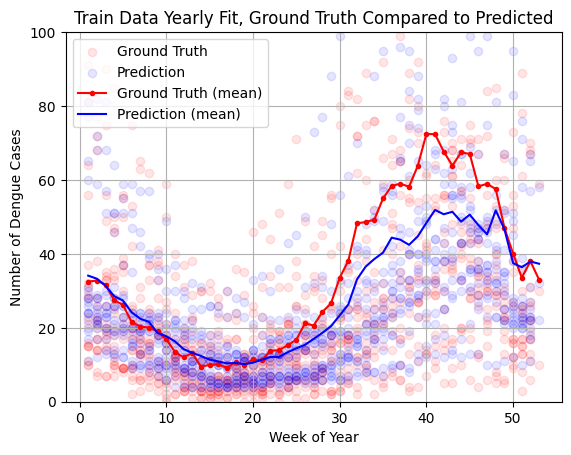

In [16]:
# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Create XGBoost model and fit using modelfit
model_sj = create_XGBmodel(eta=eta,n_estimators=n_estimators,max_depth=max_depth,
                                     min_child_weight=min_child_weight,
                                     objective='reg:squarederror',
                                     reg_alpha=reg_alpha,reg_lambda=reg_lambda)
modelfit(model_sj, sj_features, sj_labels,
        useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
        trainCV_metrics = 'mae', eval_metric = 'mae',
        report_metric = metrics.mean_absolute_error, verbose=False)

# Get predicted values for train set
sj_train_pred = get_predictions(model_sj, sj_features, label_lags)

# Add weekofyear column to ground truth and predicted target values
df_temp = sj_labels.copy()
df_temp['weekofyear'] = train_features_or.loc[train_features_or['city']=='sj','weekofyear']
df_temp2 = df_temp.copy()
df_temp2['total_cases'] = sj_train_pred
df_temp3 = df_temp2.copy()

# Plot predicted and ground truth dengue case variation over years
plt.scatter(df_temp['weekofyear'],df_temp['total_cases'],label='Ground Truth',alpha=0.1,c='red')
plt.scatter(df_temp2['weekofyear'],df_temp2['total_cases'],label='Prediction',alpha=0.1,c='blue')
plt.plot(df_temp.groupby('weekofyear').mean(),'.-',label='Ground Truth (mean)',c='red')
plt.plot(df_temp2.groupby('weekofyear').mean(),label='Prediction (mean)',c='blue')
plt.legend()
plt.grid()
plt.ylim([0,100])
plt.ylabel('Number of Dengue Cases')
plt.xlabel('Week of Year')
plt.title('Train Data Yearly Fit, Ground Truth Compared to Predicted')

While the same inverted sine curve is seen, the predicted values appear to be unable to capture the yearly peak in the second half of the year. This may be an artefact of the XGBoost model implementation here, which cannot natively account for inaccurate lagged target values during training for the multi-step forecasting scenario. We perform two extra processing steps to nudge the predicted dengue counts to an earlier peak:
1. We enforce the required pattern using `circular_weekofyear=2` in `preprocess`, transforming the `weekofyear` variable into an inverted sine curve;
2. We shift the encoded `weekofyear` variable by 10 weeks through `weekofyear_shift=10` in the `preprocess` function, to encourage a faster reaction to rising cases in the second half of the year.


 ~~~~~~~~~~~~~~ Running fold 1 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported

 ~~~~~~~~~~~~~~ Running fold 2 of 5 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are su

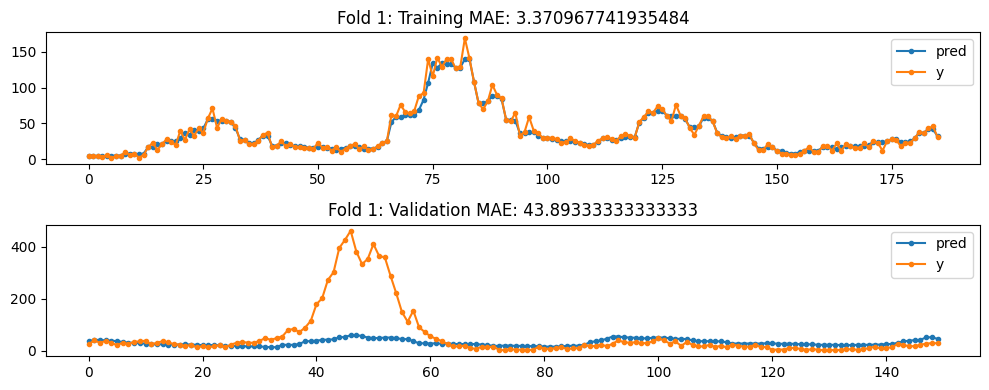

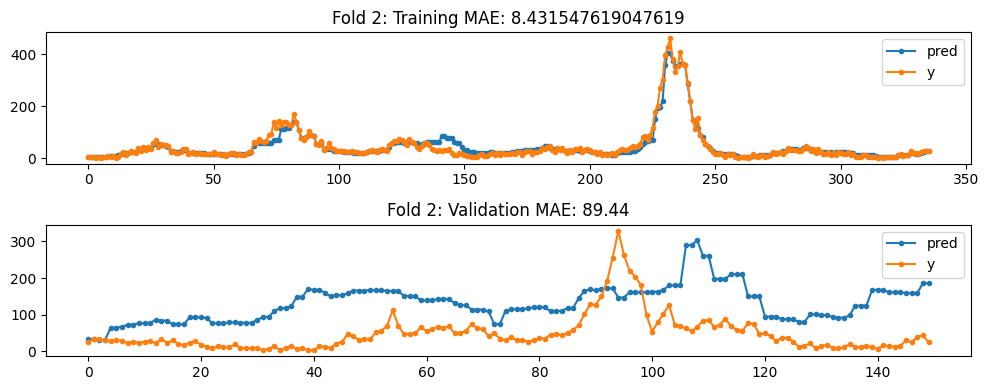

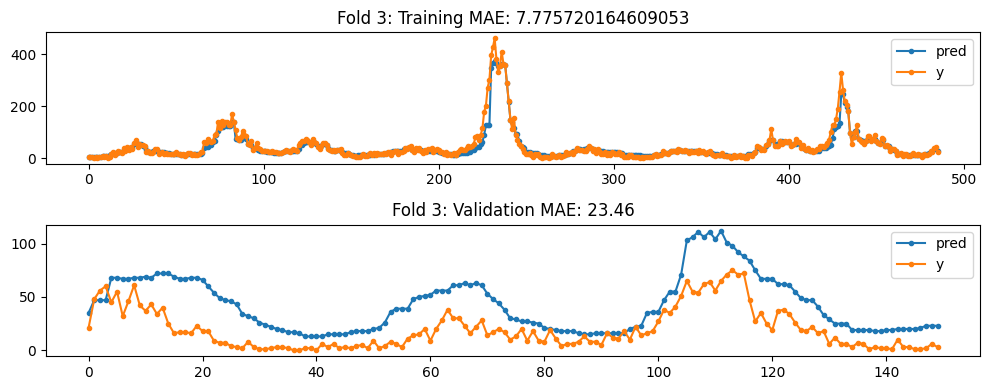

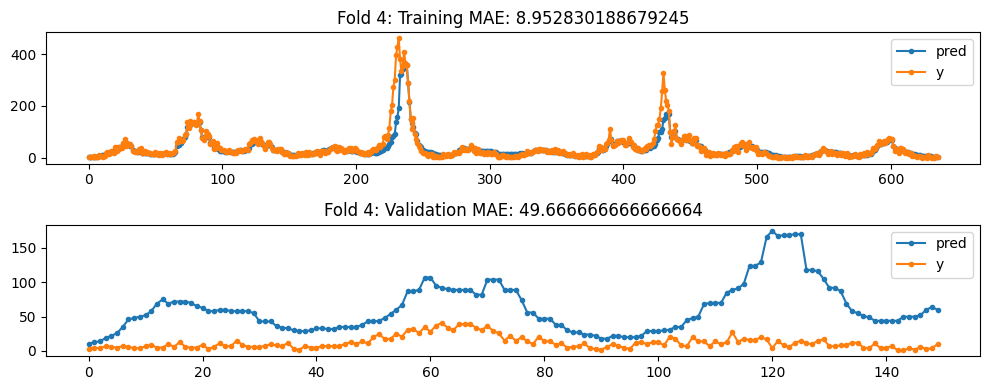

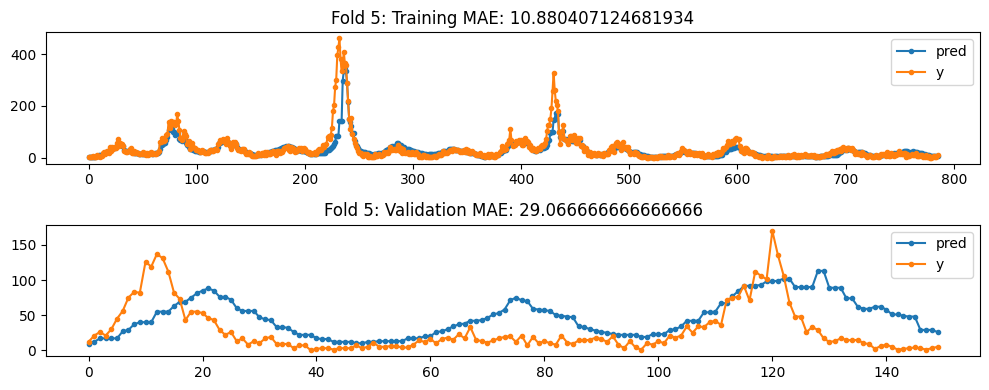

In [17]:
# Custom lag configuration with different lags for different features
label_lags=(3,4)
feature_lags=None
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']
lagged_features = {col:[1,2,3] for col in lagged_feature_names if ('ndvi' in col)}  # (1,2,3) lags for ndvi features
lagged_features_others = {col:(2,5,8) for col in lagged_feature_names if not ('ndvi' in col)} # (2,5,8) lags for weather features
lagged_features.update(lagged_features_others)

# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_features,        # feature_name: lag pairs in dictionary for custom lag configuration
                                                            feature_lags = feature_lags,              # Lags to consider for lagged features
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=2,                    # Encode weekofyear as inverted since curve
                                                            weekofyear_shift=10,                      # Shift encoded weekofyear by 10 weeks to induce faster reaction to changes in dengue cases
                                                            smooth_feat=3)                            # Apply median filtering with 3 week window for features
sj_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Use time series split for train-val sets
X_train_sj, X_val_sj, y_train_sj, y_val_sj = [],[],[],[]
tscv = TimeSeriesSplit(n_splits=5,test_size=150)
for i, (train_index, test_index) in enumerate(tscv.split(sj_features)):
    X_train_sj.append(sj_features.iloc[train_index,:])
    X_val_sj.append(sj_features.iloc[test_index,:])
    y_train_sj.append(sj_labels.iloc[train_index,:])
    y_val_sj.append(sj_labels.iloc[test_index,:])

# Evaluating and plotting over multiple folds
folds = len(X_train_sj)
xg_reg_sj = []
for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    xg_reg_sj.append(create_XGBmodel(
        eta=eta,n_estimators=n_estimators,max_depth=max_depth,          # Creating and storing XGBoost models trained for each fold
        objective='reg:squarederror',
        reg_alpha=reg_alpha,reg_lambda=reg_lambda))

    modelfit(xg_reg_sj[fold], X_train_sj[fold], y_train_sj[fold],       # Use modelfit function to use i CV for selecting 
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False)
    pred_train_sj, pred_val_sj,\
    train_mae_sj, val_mae_sj = eval_and_plot(xg_reg_sj[fold],X_train_sj[fold].sort_index(),y_train_sj[fold].sort_index(),
                                             X_val_sj[fold],y_val_sj[fold],
                                             verbose=False,plot=True,
                                             label_lags = label_lags,
                                             get_pred_train=True,        # Activate sequential prediction approach for multi-step forecasting
                                             median_filter=3,            # Median filter output
                                             plot_title_header=f'Fold {fold+1}: '
                                            )

We refit to the full training data and again check for predicted trends against ground truth.

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported


Text(0.5, 1.0, 'Train Data Yearly Fit, Ground Truth Compared to Predicted')

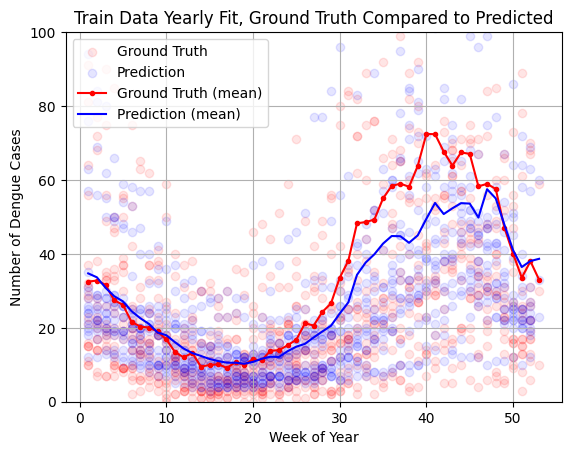

In [18]:
# Fit XGBoost to full train dataset using current configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Create XGBoost model and fit using modelfit
model_sj = create_XGBmodel(eta=eta,n_estimators=n_estimators,max_depth=max_depth,
                                     min_child_weight=min_child_weight,
                                     objective='reg:squarederror',
                                     reg_alpha=reg_alpha,reg_lambda=reg_lambda)
modelfit(model_sj, sj_features, sj_labels,
        useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
        trainCV_metrics = 'mae', eval_metric = 'mae',
        report_metric = metrics.mean_absolute_error, verbose=False)

# Get predicted values for train set
sj_train_pred = get_predictions(model_sj, sj_features, label_lags)

# Add weekofyear column to ground truth and predicted target values
df_temp = sj_labels.copy()
df_temp['weekofyear'] = train_features_or.loc[train_features_or['city']=='sj','weekofyear']
df_temp2 = df_temp.copy()
df_temp2['total_cases'] = sj_train_pred

# Plot predicted and ground truth dengue case variation over years
plt.scatter(df_temp['weekofyear'],df_temp['total_cases'],label='Ground Truth',alpha=0.1,c='red')
plt.scatter(df_temp2['weekofyear'],df_temp2['total_cases'],label='Prediction',alpha=0.1,c='blue')
plt.plot(df_temp.groupby('weekofyear').mean(),'.-',label='Ground Truth (mean)',c='red')
plt.plot(df_temp2.groupby('weekofyear').mean(),label='Prediction (mean)',c='blue')
plt.legend()
plt.grid()
plt.ylim([0,100])
plt.ylabel('Number of Dengue Cases')
plt.xlabel('Week of Year')
plt.title('Train Data Yearly Fit, Ground Truth Compared to Predicted')

As shown, the fit in the second half of the year has improved.

## San Juan Model

Putting everything together, we make a prediction for the test set for later submission.

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported


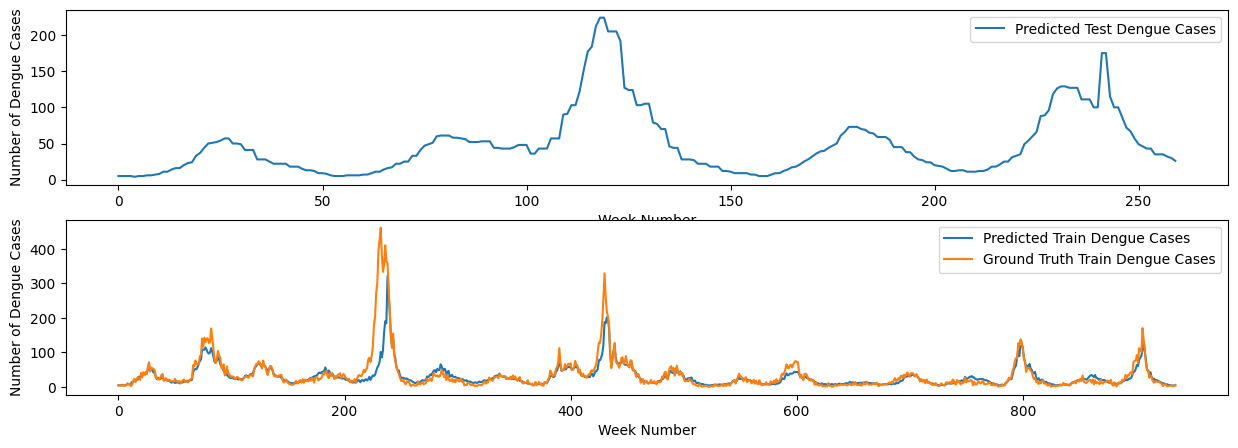

In [19]:
# Custom lag configuration with different lags for different features
label_lags=(3,4)
feature_lags=None
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']
lagged_features = {col:[1,2,3] for col in lagged_feature_names if ('ndvi' in col)}  # (1,2,3) lags for ndvi features
lagged_features_others = {col:(2,5,8) for col in lagged_feature_names if not ('ndvi' in col)} # (2,5,8) lags for weather features
lagged_features.update(lagged_features_others)

# XGBoost model configuration
n_estimators = 500
eta = 0.01
max_depth = 5
min_child_weight = 1
reg_alpha=0.5
reg_lambda=0.5

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_features,        # feature_name: lag pairs in dictionary for custom lag configuration
                                                            feature_lags = feature_lags,              # Lags to consider for lagged features
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=2,                    # Encode weekofyear as inverted since curve
                                                            weekofyear_shift=10,                      # Shift encoded weekofyear by 10 weeks to induce faster reaction to changes in dengue cases
                                                            smooth_feat=3)                            # Apply median filtering with 3 week window for features
sj_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Create XGBoost model and fit using modelfit
model_sj = create_XGBmodel(eta=eta,n_estimators=n_estimators,max_depth=max_depth,
                                     min_child_weight=min_child_weight,
                                     objective='reg:squarederror',
                                     reg_alpha=reg_alpha,reg_lambda=reg_lambda)
modelfit(model_sj, sj_features, sj_labels,
        useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
        trainCV_metrics = 'mae', eval_metric = 'mae',
        report_metric = metrics.mean_absolute_error, verbose=False)

# Preprocess test data in similar way for approprite lagged values
if label_lags is not None:          # Provide lagged target names for proper extraction from augmented test features dataframe
    lagged_label_names = ['total_cases_'+str(i) for i in label_lags]
else:
    lagged_label_names = []
sj_pred_features_aug, _, _, _ = preprocess(test_features_aug_or,
                                           features_to_keep = feature_names + lagged_label_names,
                                           lagged_features = lagged_features,
                                           fillna = 'ffill', smooth_feat = 3,
                                           feature_lags=None, label_lags=None,
                                           circular_weekofyear=2,weekofyear_shift=10)

# Make forecast for test set using trained model
sj_mask = sj_pred_features_aug['city_sj']
iq_mask = ~sj_mask
sj_pred_features_aug = sj_pred_features_aug.copy().loc[sj_mask,[col for col in sj_pred_features_aug.columns if col != 'city_sj']]
order_needed = sj_features.columns.to_list()
sj_pred_features_aug = sj_pred_features_aug[order_needed]
sj_sub_pred = get_predictions(model_sj, sj_pred_features_aug, label_lags)
sj_sub_pred = medfilt(sj_sub_pred,3)

# Plot predicted test dengue cases
fig,axs = plt.subplots(2,1,figsize=(15,5))
axs[0].plot(sj_sub_pred,label='Predicted Test Dengue Cases')
axs[0].set_ylabel('Number of Dengue Cases')
axs[0].set_xlabel('Week Number')
axs[0].legend()

# Plot predicted train dengue cases superimposed on ground truth
sj_train_pred = get_predictions(model_sj, sj_features, label_lags)
axs[1].plot(sj_train_pred,label='Predicted Train Dengue Cases')
axs[1].plot(sj_labels,label='Ground Truth Train Dengue Cases')
axs[1].set_ylabel('Number of Dengue Cases')
axs[1].set_xlabel('Week Number')
axs[1].legend()

## Iquitos Model

A similar customization process is undertaken for the Iquitos model, giving the model provided below. The Iquitos model differs from the San Juan model in the following respects:
1. __No target lags:__ The Iquitos dengue case trends appear a little more erratic, with short bursts of peaks. Therefore, no target lags are included here.
2. __Different feature lags:__ Feature lags of (1,2,3,4,5,6) weeks appear to give more stable predictions. While peaks are not effectively captured, rising trends appear to respond more to this set of feature lags.
3. __Poisson objective function:__ The `count:poisson` objective function gives a better match here than in the San Juan case. The `reg:squarederror` function may have worked better for San Juan due to an overall larger mean value.
4. __No `weekofyear` shifting__: `weekofyear` shifting appears to give inferior matches in the validation sets. None is applied here.
5. __No output median filtering__: As Iquitos trends appear to be erratic themselves (relative to the running mean), no median filtering is applied here.


 ~~~~~~~~~~~~~~ Running fold 1 of 3 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported

 ~~~~~~~~~~~~~~ Running fold 2 of 3 ~~~~~~~~~~~~~~ 
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are su

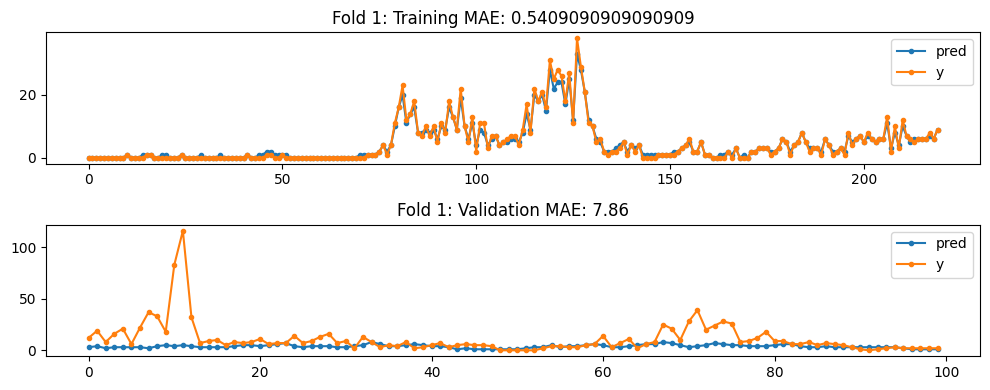

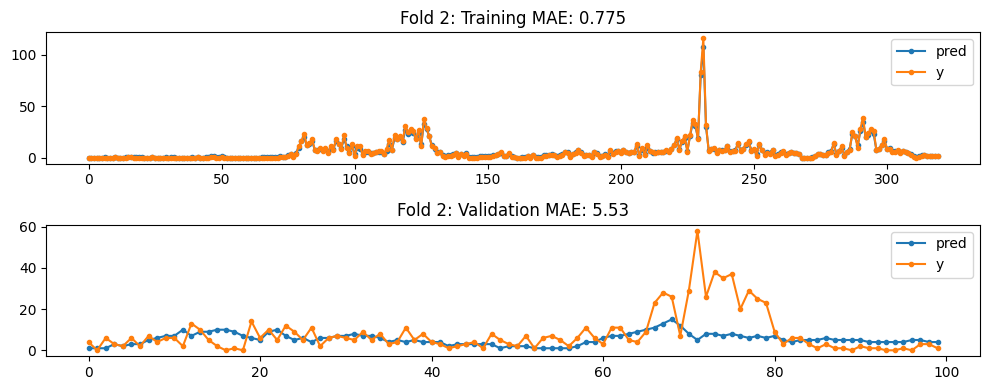

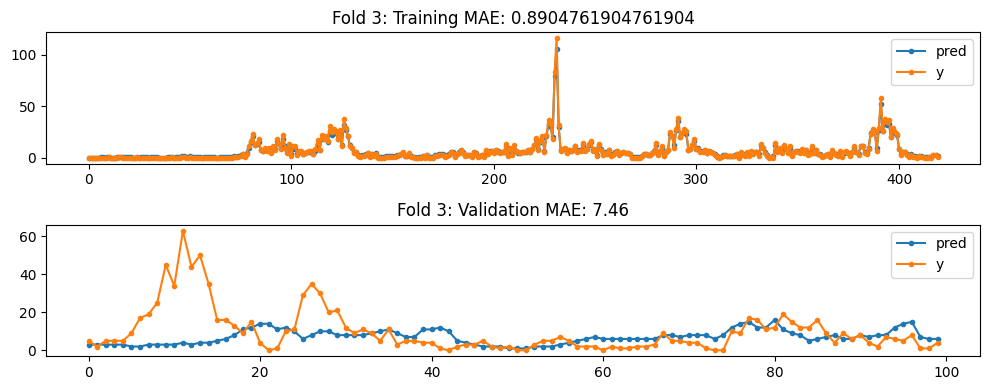

In [20]:
# Lag configuration
label_lags = None
feature_lags=(1,2,3,4,5,6)
features_to_keep = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_feature_names = [col for col in features_to_keep if col !='weekofyear']

# XGBoost model configuration
n_estimators = 1000
eta = 0.01
max_depth = 7
min_child_weight = 1
reg_alpha=1
reg_lambda=1
smooth_feat = 3

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,
                                                            labels=train_labels,
                                                            features_to_keep = features_to_keep,      # Include all non-date and -location features
                                                            lagged_features = lagged_feature_names,   # Column names of features to create lagged values for
                                                            feature_lags = feature_lags,              # Lags to consider for lagged features
                                                            label_lags=label_lags,                    # Lags to consider for target
                                                            fillna = 'ffill',                         # Forward fill missing values
                                                            circular_weekofyear=2,                    # Encode weekofyear as inverted since curve
                                                            smooth_feat=3)                         # Apply median filtering with 3 week window for features
iq_features.drop(columns=['city_sj'],inplace=True)          # Drop city column

# Use time series split for train-val sets
X_train_iq, X_val_iq, y_train_iq, y_val_iq = [],[],[],[]
tscv = TimeSeriesSplit(n_splits=3,test_size=100)
for i, (train_index, test_index) in enumerate(tscv.split(iq_features)):
    X_train_iq.append(iq_features.iloc[train_index,:])
    X_val_iq.append(iq_features.iloc[test_index,:])
    y_train_iq.append(iq_labels.iloc[train_index,:])
    y_val_iq.append(iq_labels.iloc[test_index,:])

# Evaluating and plotting over multiple folds
folds = len(X_train_iq)
xg_reg_iq = []
for fold in range(folds):
    print(f'\n ~~~~~~~~~~~~~~ Running fold {fold+1} of {folds} ~~~~~~~~~~~~~~ ')
    xg_reg_iq.append(create_XGBmodel(
        eta=eta,n_estimators=n_estimators,max_depth=max_depth,          # Creating and storing XGBoost models trained for each fold
        objective='count:poisson',
        reg_alpha=reg_alpha,reg_lambda=reg_lambda))

    modelfit(xg_reg_iq[fold], X_train_iq[fold], y_train_iq[fold],       # Use modelfit function to use i CV for selecting 
            useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
            trainCV_metrics = 'mae', eval_metric = 'mae',
            report_metric = metrics.mean_absolute_error, verbose=False)
    pred_train_iq, pred_val_iq,\
    train_mae_iq, val_mae_iq = eval_and_plot(xg_reg_iq[fold],X_train_iq[fold].sort_index(),y_train_iq[fold].sort_index(),
                                             X_val_iq[fold],y_val_iq[fold],
                                             verbose=False,plot=True,
                                             label_lags = label_lags,
                                             get_pred_train=True,        # Activate sequential prediction approach for multi-step forecasting
                                             median_filter=None,            # Median filter output
                                             plot_title_header=f'Fold {fold+1}: '
                                            )

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported


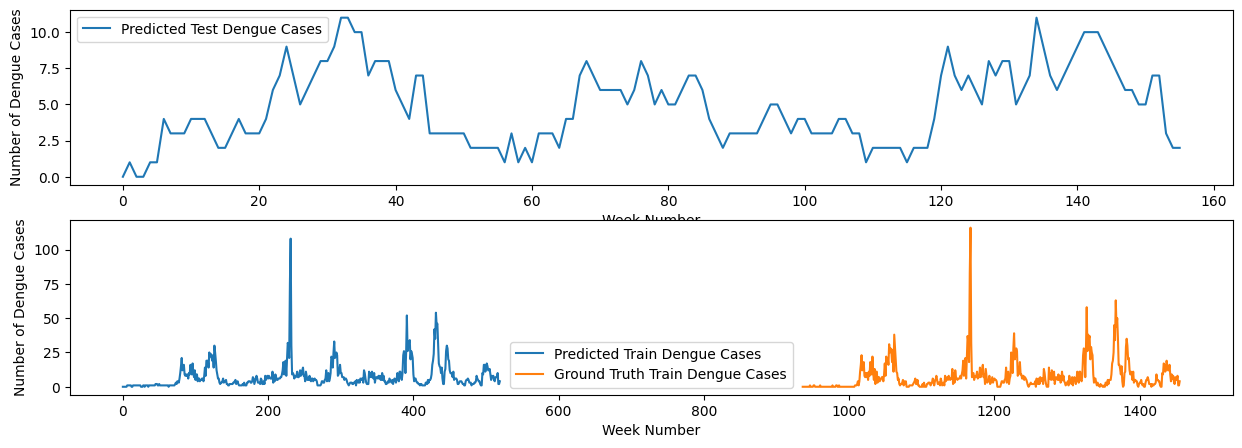

In [21]:
# Create XGBoost model and fit using modelfit
model_iq = create_XGBmodel(eta=eta,n_estimators=n_estimators,max_depth=max_depth,
                                     objective='count:poisson',
                                     reg_alpha=reg_alpha,reg_lambda=reg_lambda)

modelfit(model_iq, iq_features, iq_labels,
        useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
        trainCV_metrics = 'mae', eval_metric = 'mae',
        report_metric = metrics.mean_absolute_error, verbose=False)
if label_lags is not None:
    lagged_label_names = ['total_cases_'+str(i) for i in label_lags]
else:
    lagged_label_names = []

_, iq_pred_features_aug, _, _ = preprocess(test_features_aug_or,
                                  features_to_keep = feature_names + lagged_label_names,
                                  lagged_features = lagged_feature_names, smooth_feat = 3,
                                  fillna = 'ffill', feature_lags=feature_lags,
                                  label_lags=None,circular_weekofyear=2)

# Make forecast for test set using trained model
sj_mask = iq_pred_features_aug['city_sj']
iq_mask = ~sj_mask
iq_pred_features_aug = iq_pred_features_aug.copy().loc[iq_mask,[col for col in iq_pred_features_aug.columns if col != 'city_sj']]
order_needed = iq_features.columns.to_list()
iq_pred_features_aug = iq_pred_features_aug[order_needed]
iq_sub_pred = get_predictions(model_iq, iq_pred_features_aug, label_lags)

# Plot predicted test dengue cases
fig,axs = plt.subplots(2,1,figsize=(15,5))
axs[0].plot(iq_sub_pred,label='Predicted Test Dengue Cases')
axs[0].set_ylabel('Number of Dengue Cases')
axs[0].set_xlabel('Week Number')
axs[0].legend()

# Plot predicted train dengue cases superimposed on ground truth
iq_train_pred = get_predictions(model_iq, iq_features, label_lags)
axs[1].plot(iq_train_pred,label='Predicted Train Dengue Cases')
axs[1].plot(iq_labels,label='Ground Truth Train Dengue Cases')
axs[1].set_ylabel('Number of Dengue Cases')
axs[1].set_xlabel('Week Number')
axs[1].legend()

## Final Submission File

We combine the predictions for San Juan and Iquitos for final submission.

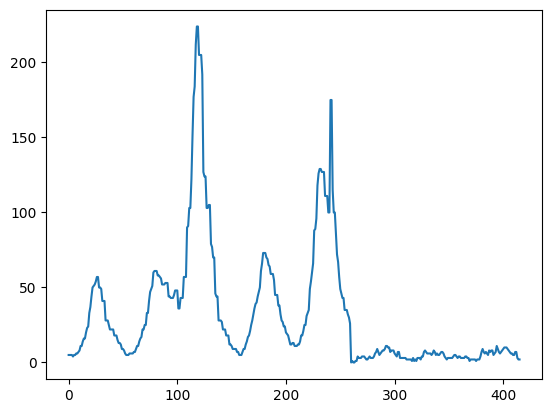

In [22]:
# Create and plot final submission file
submission = pd.read_csv(datapath+"/submission_format.csv",
                         index_col=[0, 1, 2])
submission.total_cases = np.hstack([sj_sub_pred,iq_sub_pred]).astype(int)
plt.plot(np.hstack([sj_sub_pred,iq_sub_pred]).astype(int))
submission.to_csv("./submission.csv")